## Project Overview: 
In 2012, CMS began reducing Medicare payments for subsection(d) hospitals with excess readmissions under the Hospital Readmission Reduction Program. Excess readmissions are measured by a ratio, calculated by dividing a hospital's predicted Readmission Rate (RR) for heart attack, heart failure, pneumonia, chronic obstructive pulmonary disease, hip/knee replacement, and coronary artery bypass graft surgery by expected RR, based on an average hospital with similar patients.

We have been approached by leadership of a medium-large sized (approx. 2700 Medicare reimbursed inpatient cases per year) public hospital in New Jersey (Facility_ID == '310041'). In their annual review, CMS flagged the hospital as having a higher than expected RR and informed them they would be subject to reduced payments in 1 year if this rate (approx. 17%) did not improve by 1% to align with what CMS expects given their own model’s assumptions. 
 
The hospital’s leadership wants us to help then conduct their own analysis of factors most related to RR in hospitals of comparable size, and then come up with an evidence-driven plan to avoid a penalty that they have determined would substantially affect their ability to provide quality care. Even if the analysis reveals that factors largely out of their control (e.g., demographics in the area of the hospital, case volume, case mix) are responsible for their higher than expected RR rate according to CMS, the hospital administrators feel that this can be baked into a reply letter to CMS that may help forestall a reduction in Medicare reimbursement that would certainly negatively impact care at the facility.

## Data Wrangling
### 1. Imports
Loading in useful packages 

In [1]:
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### 2. Loading Target Data
Data file containing our putative target feature (inpatient 30-Day Hospital Readmission Rate [RR])

In [2]:
#Get URL of file containing target feature data and save locally
url ='https://data.cms.gov/provider-data/sites/default/files/resources/37e3c1486ad47b7a0eb471ecf3f7e428_1632355521/Unplanned_Hospital_Visits-Hospital.csv'
urlretrieve(url,'Unplanned_Hospital_Visits-Hospital.csv')

#Read into a DF the CMS.gov file containing the target feature (Readmission Rate) Pre-saved local copy code.
#outcomes_data = pd.read_csv('../raw_data/Unplanned_Hospital_Visits-Hospital.csv')

('Unplanned_Hospital_Visits-Hospital.csv',
 <http.client.HTTPMessage at 0x2219aa3df70>)

In [3]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
outcomes_data = pd.read_csv('Unplanned_Hospital_Visits-Hospital.csv', na_values=missing_values)
#print(outcomes_data.head())

In [4]:
#High-level look at data. From CMS documentation, we know 'Score' is the variable representing Readmission Rate within 30 days of
#original discharge(our putative target feature) and 'Measure Name' describes the measure in the file for each row.
outcomes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67970 entries, 0 to 67969
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Facility ID                  67970 non-null  object 
 1   Facility Name                67970 non-null  object 
 2   Address                      67970 non-null  object 
 3   City                         67970 non-null  object 
 4   State                        67970 non-null  object 
 5   ZIP Code                     67970 non-null  int64  
 6   County Name                  67970 non-null  object 
 7   Phone Number                 67970 non-null  object 
 8   Measure ID                   67970 non-null  object 
 9   Measure Name                 67970 non-null  object 
 10  Compared to National         39869 non-null  object 
 11  Denominator                  39055 non-null  float64
 12  Score                        39055 non-null  float64
 13  Lower Estimate  

### 3. Investigating and Tidying Target (RR) Data 
Also investigating other potentially useful data for target prediction from the same file

In [5]:
#Renaming columns per tidy data conventions, and to be more descriptive where possible. 
outcomes_data = outcomes_data.set_axis(["Facility_ID", "Facility_Name", "Address", "City", "State","ZIP", "County","Phone", "Measure_ID", "Measure_Name", "RR_vs_National", "Total_Admissions", "ReadmissionRate", "RR_Lower_Est", "RR_Upper_Est","Number_Pts_nonrelevant","Number_Pts_Returned_nonrelevant","Footnote","Start_Date","End_Date"], axis=1)
outcomes_data.head()

,Facility_ID,Facility_Name,Address,City,State,ZIP,County,Phone,Measure_ID,Measure_Name,RR_vs_National,Total_Admissions,ReadmissionRate,RR_Lower_Est,RR_Upper_Est,Number_Pts_nonrelevant,Number_Pts_Returned_nonrelevant,Footnote,Start_Date,End_Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,EDAC_30_AMI,Hospital return days for heart attack patients,Average Days per 100 Discharges,424.0,6.5,-8.1,23.7,406.0,116.0,NaN,07/01/2017,12/01/2019
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,EDAC_30_HF,Hospital return days for heart failure patients,More Days Than Average per 100 Discharges,904.0,16.1,1.1,33.1,691.0,244.0,NaN,07/01/2017,12/01/2019
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,EDAC_30_PN,Hospital return days for pneumonia patients,Average Days per 100 Discharges,503.0,-7.1,-21.2,8.2,462.0,117.0,NaN,07/01/2017,12/01/2019
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,OP_32,Rate of unplanned hospital visits after colono...,No Different Than the National Rate,511.0,14.1,10.4,19.2,NaN,NaN,NaN,01/01/2017,12/24/2019
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,OP_35_ADM,Rate of inpatient admissions for patients rece...,No Different Than the National Rate,192.0,11.3,8.8,14.2,NaN,NaN,NaN,01/01/2019,12/01/2019


In [6]:
#We can set aside for now and save off (might be useful later) a number of columns that we know we don't need upfront from reviewing CMS documentation (https://data.cms.gov/provider-data/sites/default/files/data_dictionaries/hospital/HospitalCompare-DataDictionary.pdf)
#Done in two steps so we can keep 'Facility_ID' in both dfs as a join column for later if needed
#Also saving off full 'RR_vs_National' column before we filter outcomes_data down, but also will keep a copy in 'outcomes_data' for now for a little EDA
other_data = outcomes_data[['Facility_ID','RR_vs_National','Address','ZIP','Phone','Footnote', 'Start_Date','End_Date','Number_Pts_nonrelevant','Number_Pts_Returned_nonrelevant','RR_Lower_Est','RR_Upper_Est','Facility_Name','Measure_Name','Measure_ID']]
other_data.to_csv('../data/other_data.csv', index=False)
outcomes_data = outcomes_data.drop(['Address','ZIP','Phone','Footnote', 'Start_Date','End_Date','Number_Pts_nonrelevant','Number_Pts_Returned_nonrelevant','RR_Lower_Est','RR_Upper_Est','Facility_Name'], axis=1)
outcomes_data.info()
#other_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67970 entries, 0 to 67969
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Facility_ID       67970 non-null  object 
 1   City              67970 non-null  object 
 2   State             67970 non-null  object 
 3   County            67970 non-null  object 
 4   Measure_ID        67970 non-null  object 
 5   Measure_Name      67970 non-null  object 
 6   RR_vs_National    39869 non-null  object 
 7   Total_Admissions  39055 non-null  float64
 8   ReadmissionRate   39055 non-null  float64
dtypes: float64(2), object(7)
memory usage: 4.7+ MB


In [7]:
#We can see that the df with the target feature contains multiple outcomes per hospital-we'll want only rows measuring Score for Hospital-Wide Readmission Rate for now.
outcomes_data[['Measure_ID','Measure_Name']].value_counts()

Measure_ID          Measure_Name                                                                           
EDAC_30_AMI         Hospital return days for heart attack patients                                             4855
EDAC_30_HF          Hospital return days for heart failure patients                                            4855
EDAC_30_PN          Hospital return days for pneumonia patients                                                4855
OP_32               Rate of unplanned hospital visits after colonoscopy (per 1,000 colonoscopies)              4855
OP_35_ADM           Rate of inpatient admissions for patients receiving outpatient chemotherapy                4855
OP_35_ED            Rate of emergency department (ED) visits for patients receiving outpatient chemotherapy    4855
OP_36               Ratio of unplanned hospital visits after hospital outpatient surgery                       4855
READM_30_AMI        Acute Myocardial Infarction (AMI) 30-Day Readmission Rate   

In [8]:
#Filter the dataframe down to just rows representing overall 30-day Readmission Rate, per hospital
outcomes_data = outcomes_data[outcomes_data["Measure_ID"].str.contains("READM_30_HOSP_WIDE")==True]

In [9]:
outcomes_data = outcomes_data.drop(['Measure_Name','Measure_ID'], axis=1) #Full columns previously saved off to other_data

In [10]:
#We now want to filter down to only hospitals that actually have RR and Total_Admissions reported. 
#This leaves us with ~4000 hospitals that have target data and overall initial admissions/case load data. 
outcomes_data = outcomes_data.dropna(subset=['Total_Admissions','ReadmissionRate'])
outcomes_data.shape
#This leaves us with ~4000 hospitals that have target data and overall initial admissions/case load data. 

(4117, 7)

In [11]:
#We saw earlier that Total_Admissions and ReadmissionRate (target feature) were read in as objects, but we want them to be numeric
outcomes_data['ReadmissionRate'] = outcomes_data['ReadmissionRate'].astype(float, errors = 'raise')
outcomes_data['Total_Admissions'] = outcomes_data['Total_Admissions'].astype(int, errors = 'raise')

In [12]:
outcomes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4117 entries, 12 to 67772
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Facility_ID       4117 non-null   object 
 1   City              4117 non-null   object 
 2   State             4117 non-null   object 
 3   County            4117 non-null   object 
 4   RR_vs_National    4117 non-null   object 
 5   Total_Admissions  4117 non-null   int32  
 6   ReadmissionRate   4117 non-null   float64
dtypes: float64(1), int32(1), object(5)
memory usage: 241.2+ KB


In [13]:
#Checking if any columns still included are missing values, and the answer is no!
missing = pd.concat([outcomes_data.isnull().sum(), 100 * outcomes_data.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

,count,%
Facility_ID,0,0.0
City,0,0.0
State,0,0.0
County,0,0.0
RR_vs_National,0,0.0
Total_Admissions,0,0.0
ReadmissionRate,0,0.0


In [14]:
#Checking if all of the hospitals remaining in the file are uniques (using Facility ID, since there are quite a number of common hospital names)
outcomes_data['Facility_ID'].value_counts().head()

#Things look good-no dupes

230254    1
050197    1
520071    1
310111    1
130028    1
Name: Facility_ID, dtype: int64

In [15]:
outcomes_data.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate
12,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5
26,010005,BOAZ,AL,Marshall,No Different Than the National Rate,764,14.7
40,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7
54,010007,OPP,AL,Covington,No Different Than the National Rate,144,15.7
68,010008,LUVERNE,AL,Crenshaw,No Different Than the National Rate,38,15.3


In [16]:
outcomes_data["State"].value_counts()

CA    311
TX    306
FL    175
IL    166
NY    154
OH    151
PA    151
MI    118
WI    116
KS    113
IN    112
GA    109
NC    104
MO     98
OK     98
IA     98
LA     95
TN     91
KY     85
MN     80
AL     80
VA     80
WA     76
CO     75
MS     74
AR     70
AZ     68
NE     66
NJ     65
MA     59
OR     58
SC     57
MD     45
WV     44
PR     43
SD     42
UT     41
NM     36
ID     35
MT     34
ME     33
ND     29
NV     29
CT     27
NH     26
WY     23
VT     15
AK     14
HI     13
RI     11
DC      7
DE      7
VI      2
GU      1
MP      1
Name: State, dtype: int64

In [17]:
#Dropping hospitals in US territories (non-states)
outcomes_data = outcomes_data[(outcomes_data.State != 'PR') & (outcomes_data.State != 'MP') & (outcomes_data.State != 'VI') & (outcomes_data.State != 'GU')]

### 4. Some Initial EDA: Filtering by Total Admissions 

Our client has a case load of ~2700. We want to strike a balance where we don't exclude too many hospitals from the analysis, but also don't include hospitals with very small case loads. The reason for excluding very small hospitals is two-fold: 1) what drives RR at these hospitals may not be representative of what drives RR at larger hospitals; 2) hospitals with very few overall admissions will have inherently more noisy estimates of readmission rate and other useful features. 

Below is some preliminary EDA that verifies the intuition that small hospitals in the data set have noisier data (they are far less likely to be deemed above or below the National Rate of RR by CMS' own proprietary model than if the threshold is set a little higher).  


In [18]:
# Getting a sense of case loads ('Total_Admissions') per hospital. 
#We can see that over half of the hospitals in the database are "small" (below 500 cases). We can filter down to <=1500 cases 
#potentially and still have nearly 500 hospitals to work with. Our client comes in at ~2700 cases, so this will be a good
#compromise between compressing the caseload range too much and using a sample that is size-representative of our client. 
denom_binning = pd.concat([outcomes_data.Total_Admissions.value_counts(normalize=True, sort = False, bins = [0, 100, 500, 1000, 1500, 2000,3000, 4000, 5000]),
                outcomes_data.Total_Admissions.value_counts(sort = False, bins = [0, 100, 500, 1000, 1500, 2000, 3000, 4000, 5000])], 
                axis=1,
                keys=('perc','count'))
print (denom_binning)

                      perc  count
(-0.001, 100.0]   0.257494   1048
(100.0, 500.0]    0.327273   1332
(500.0, 1000.0]   0.171007    696
(1000.0, 1500.0]  0.110319    449
(1500.0, 2000.0]  0.059951    244
(2000.0, 3000.0]  0.049386    201
(3000.0, 4000.0]  0.015971     65
(4000.0, 5000.0]  0.005160     21


In [19]:
#CMS has their own model for determining whether a hospital is above, below or at the national average for ReadmissionRate. 
#It's useful to take a quick look at how this is affected with and without filtering out the smaller hospitals in the sample.
outcomes_data['RR_vs_National'][outcomes_data['Total_Admissions'] < 1500].value_counts(normalize = True)

No Different Than the National Rate    0.975035
Worse Than the National Rate           0.017872
Better Than the National Rate          0.007092
Name: RR_vs_National, dtype: float64

In [20]:
#When comparing to the above, it's clear that a much larger proportion of hospitals differ significantly from the national
#average when removing the ones with low case load. This is very likely due to the fact that rate estimate is much noisier 
#the caseload is "too small"
outcomes_data['RR_vs_National'][outcomes_data['Total_Admissions'] >= 1500].value_counts(normalize = True)

No Different Than the National Rate    0.851376
Worse Than the National Rate           0.082569
Better Than the National Rate          0.066055
Name: RR_vs_National, dtype: float64

In [21]:
#Backing up the above assertion is the fact that the % significantly different from the national average increases substantially
#with simply boosting the threshold to 500 cases
outcomes_data['RR_vs_National'][outcomes_data['Total_Admissions'] >= 500].value_counts(normalize = True) 

No Different Than the National Rate    0.903073
Worse Than the National Rate           0.060875
Better Than the National Rate          0.036052
Name: RR_vs_National, dtype: float64

* The above is good evidence that by restricting caseload range somewhat to align with our client's parameters, we are not stripping away many cases that CMS deems to deviate from the national average. In fact, we're probably removing a lot of noisy low end volume hospitals tht might confound our eventual model with their noisiness. Based on this, we will include only hospitals with 1000 or more outpatient cases (ie, denominator for readmission rate) moving forward in the analysis

In [22]:
#Keeping only hospitals with >1000 total admissions for further analysis
outcomes_data_hipass = outcomes_data[outcomes_data['Total_Admissions'] >= 1000]
outcomes_data_hipass.shape
outcomes_data = outcomes_data.drop(['RR_vs_National'], axis=1) #we have this variable in other_data if weneed it later

### 5. CMS Infection Rate Data as Features to Predict RR
Beginning to pull in potentially useful features for prediction of RR from other CMS databases

In [23]:
#Read into a DF the CMS.gov file containing inpatient infection rates at hospital level
url ='https://data.cms.gov/provider-data/sites/default/files/resources/05819383a875a1ebce5ed5f28755558b_1632355514/Healthcare_Associated_Infections-Hospital.csv'
urlretrieve(url,'Healthcare_Associated_Infections-Hospital.csv')
#infection_rates = pd.read_csv('../raw_data/Healthcare_Associated_Infections-Hospital.csv')

('Healthcare_Associated_Infections-Hospital.csv',
 <http.client.HTTPMessage at 0x2219c02eca0>)

In [24]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
infection_rates = pd.read_csv('Healthcare_Associated_Infections-Hospital.csv', na_values=missing_values)
#print(outcomes_data.head())

In [25]:
infection_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174780 entries, 0 to 174779
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Facility ID           174780 non-null  object
 1   Facility Name         174780 non-null  object
 2   Address               174780 non-null  object
 3   City                  174780 non-null  object
 4   State                 174780 non-null  object
 5   ZIP Code              174780 non-null  int64 
 6   County Name           174780 non-null  object
 7   Phone Number          174780 non-null  object
 8   Measure ID            174780 non-null  object
 9   Measure Name          174780 non-null  object
 10  Compared to National  69984 non-null   object
 11  Score                 99442 non-null   object
 12  Footnote              82415 non-null   object
 13  Start Date            174780 non-null  object
 14  End Date              174780 non-null  object
dtypes: int64(1), obje

In [26]:
infection_rates.head()

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure ID,Measure Name,Compared to National,Score,Footnote,Start Date,End Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,HAI_1_CILOWER,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,0.203,NaN,07/01/2019,12/31/2020
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,HAI_1_CIUPPER,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,1.230,NaN,07/01/2019,12/31/2020
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,HAI_1_DOPC,Central Line Associated Bloodstream Infection:...,No Different than National Benchmark,8631,NaN,07/01/2019,12/31/2020
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,HAI_1_ELIGCASES,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,9.008,NaN,07/01/2019,12/31/2020
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,(334) 793-8701,HAI_1_NUMERATOR,Central Line Associated Bloodstream Infection ...,No Different than National Benchmark,5,NaN,07/01/2019,12/31/2020


* From the CMS Documentation, we know that a subset of this file contains standardized Healthcare Associated Infection (HAI)
measures that show how often patients in a particular hospital contract certain infections during the course of their medical treatment, when compared to like hospitals.The CDC calculates a Standardized Infection Ratio (SIR) which may take into account the type of patient care location, number of patients with an existing infection, laboratory methods, hospital affiliation with a medical school, bed size of the hospital, patient age, and classification of patient health.  

* There are 6 SIRs available in the file, but we decide that selecting the four that generalize across procedure types should give a nice representitive indication infection risk per hospital (remember that these ratios are already normed against a CDC prediction for that hospital per infection type, so they scale with case load): 1) HAI_1_SIR: Central Lines Associated Bloodstream Infections; 2) HAI_SIR_2: Catheter Associated Urinary Tract Infections;  3) HAI_5_SIR: MRSA Bacteremia. 4) HAI_6_SIR: C. Diff Infections. Later we will also create a composite feature of these SIRs per hospital. We will aim to join these rows to the outcomes measures df.  

In [27]:
#Rename the column in infection_rates that we will join our new features on to match equivalent in outcomes_data_hipass
infection_rates.rename(columns = {'Facility ID':'Facility_ID'}, inplace=True)

In [28]:
#Pulling out only rows containing the measures of interest from infection_rates, one measure at a time, and then merging into outcomes_data_hipass
HAI = infection_rates[infection_rates['Measure ID'] == 'HAI_1_SIR']
outcomes_data_hipass = outcomes_data_hipass.merge(HAI[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'HAI_1_SIR'}, inplace=True)

HAI = infection_rates[infection_rates['Measure ID'] == 'HAI_2_SIR']
outcomes_data_hipass = outcomes_data_hipass.merge(HAI[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'HAI_2_SIR'}, inplace=True)

HAI = infection_rates[infection_rates['Measure ID'] == 'HAI_5_SIR']
outcomes_data_hipass = outcomes_data_hipass.merge(HAI[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'HAI_5_SIR'}, inplace=True)

HAI = infection_rates[infection_rates['Measure ID'] == 'HAI_6_SIR']
outcomes_data_hipass = outcomes_data_hipass.merge(HAI[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'HAI_6_SIR'}, inplace=True)

outcomes_data_hipass.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,0.604
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,0.212
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,0.638
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,1.168
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,0.662


In [29]:
#Our new features were merged into outcomes_data_hipass as objects, but we want them to be numeric (floats here)
outcomes_data_hipass[['HAI_1_SIR','HAI_2_SIR','HAI_5_SIR','HAI_6_SIR']] = outcomes_data_hipass[['HAI_1_SIR','HAI_2_SIR','HAI_5_SIR','HAI_6_SIR']].astype(float, errors = 'raise')

In [30]:
#Just to be aware for later in the process, each of the SIR columns has some amount of missing values
missing = pd.concat([outcomes_data_hipass.isnull().sum(), 100 * outcomes_data_hipass.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

,count,%
HAI_5_SIR,61,6.130653
HAI_6_SIR,58,5.829146
HAI_1_SIR,13,1.306533
HAI_2_SIR,11,1.105528
Facility_ID,0,0.000000
City,0,0.000000
State,0,0.000000
County,0,0.000000
RR_vs_National,0,0.000000
Total_Admissions,0,0.000000


### 6. CMS PSI-90 Data as Features to Predict RR

Another file with promising data for features to predict RR is 'CMS Medicare PSI-90 and component measures - six-digit estimate dataset'. This data set includes the Patient Safety and Adverse Events Composite measure (CMS Medicare PSI 90) and the individual CMS Patient Safety Indicators. CMS Medicare PSI 90 is a composite complication measure composed from 10 separate Patient Safety Indicators. The measure provides an overview of hospital-level quality as it relates to a set of potentially preventable hospital-related events associated with harmful outcomes for patients. We will pull in both the individual PSIs and the composite measure.

In [31]:
#Get URL of file containing desired feature data and save locally
url ='https://data.cms.gov/provider-data/sites/default/files/resources/06f0a6eff78f06b8bee4b4bf4a1f20a2_1632441913/CMS_PSI_6_decimal_file.csv'
urlretrieve(url,'CMS_PSI_6_decimal_file.csv')

('CMS_PSI_6_decimal_file.csv', <http.client.HTTPMessage at 0x2219d5b92b0>)

In [32]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
PSI_data = pd.read_csv('CMS_PSI_6_decimal_file.csv', na_values=missing_values)
#print(outcomes_data.head())

In [33]:
PSI_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53009 entries, 0 to 53008
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Facility ID    53009 non-null  object 
 1   Facility Name  53009 non-null  object 
 2   Address        53009 non-null  object 
 3   City           53009 non-null  object 
 4   State          53009 non-null  object 
 5   ZIP Code       53009 non-null  int64  
 6   County         53009 non-null  object 
 7   Measure ID     53009 non-null  object 
 8   Measure Name   53009 non-null  object 
 9   Rate           32535 non-null  float64
 10  Footnote       20480 non-null  float64
 11  Start Date     53009 non-null  object 
 12  End Date       53009 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 5.3+ MB


In [34]:
PSI_data.head()

,Facility ID,Facility Name,Address,City,State,ZIP Code,County,Measure ID,Measure Name,Rate,Footnote,Start Date,End Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,PSI_03,Pressure ulcer rate,0.323051,NaN,07/01/2018,12/31/2019
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,PSI_06,Iatrogenic pneumothorax rate,0.159789,NaN,07/01/2018,12/31/2019
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,PSI_08,In-hospital fall with hip fracture rate,0.087809,NaN,07/01/2018,12/31/2019
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,PSI_09,Perioperative hemorrhage or hematoma rate,2.934697,NaN,07/01/2018,12/31/2019
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Houston,PSI_10,Postoperative acute kidney injury requiring di...,1.001075,NaN,07/01/2018,12/31/2019


* The 11 features we want are: PSI_03 (Pressure Ulcer Rate), PSI_06 (Iatrogenic pneumothorax rate), PSI_08 (In-hospital fall with hip fracture rate), PSI_09 (Perioperative hemorrhage or hematoma rate), PSI_10 (Postoperative acute kidney injury requiring dialysis rate), PSI_11 (Postoperative respiratory failure rate) , PSI_12 (Perioperative pulmonary embolism or deep vein thrombosis rate), PSI_13 (Postoperative sepsis rate), PSI_14 (Postoperative wound dehiscence rate), PSI_15 (Abdominopelvic accidental puncture or laceration rate), PSI_90 (CMS Medicare PSI 90: Patient safety and adverse events composite)













In [35]:
#Rename the column in PSI_data that we will join our new features on to match equivalent in outcomes_data_hipass
PSI_data.rename(columns = {'Facility ID':'Facility_ID'}, inplace=True)

In [36]:
#Pulling out only rows containing the measures of interest from PSI_data, one measure at a time, and then merging into outcomes_data_hipass
PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_03']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_3'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_06']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_6'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_08']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_8'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_09']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_9'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_10']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_10'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_11']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_11'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_12']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_12'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_13']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_13'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_14']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_14'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_15']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_15'}, inplace=True)

PSI = PSI_data[PSI_data['Measure ID'] == 'PSI_90']
outcomes_data_hipass = outcomes_data_hipass.merge(PSI[['Rate','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Rate':'PSI_90'}, inplace=True)

outcomes_data_hipass.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,PSI_6,PSI_8,PSI_9,PSI_10,PSI_11,PSI_12,PSI_13,PSI_14,PSI_15,PSI_90
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,0.159789,0.087809,2.934697,1.001075,4.207372,3.063311,4.413214,0.783725,1.273853,0.812097
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,0.304747,0.089731,2.957849,1.167554,7.195029,3.340863,4.760645,0.805441,1.144432,1.191791
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,0.282001,0.088012,2.896076,1.146343,6.423656,3.871149,4.551728,0.814864,0.919965,1.276489
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,0.262228,0.115035,1.992409,1.230762,3.238653,3.123448,4.857670,0.820121,1.168347,0.819562
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,0.183200,0.100589,2.130613,1.679249,4.410458,3.075091,3.782965,0.963131,0.880183,0.797164


In [37]:
#Our new features were merged into outcomes_data_hipass as objects, but we want them to be numeric (floats here)
outcomes_data_hipass[['PSI_6','PSI_8','PSI_9','PSI_10','PSI_11','PSI_12','PSI_13','PSI_14','PSI_15','PSI_90']] = outcomes_data_hipass[['PSI_6','PSI_8','PSI_9','PSI_10','PSI_11','PSI_12','PSI_13','PSI_14','PSI_15','PSI_90']].astype(float, errors = 'raise')

In [38]:
outcomes_data_hipass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 994
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Facility_ID       995 non-null    object 
 1   City              995 non-null    object 
 2   State             995 non-null    object 
 3   County            995 non-null    object 
 4   RR_vs_National    995 non-null    object 
 5   Total_Admissions  995 non-null    int32  
 6   ReadmissionRate   995 non-null    float64
 7   HAI_1_SIR         982 non-null    float64
 8   HAI_2_SIR         984 non-null    float64
 9   HAI_5_SIR         934 non-null    float64
 10  HAI_6_SIR         937 non-null    float64
 11  PSI_3             994 non-null    float64
 12  PSI_6             994 non-null    float64
 13  PSI_8             994 non-null    float64
 14  PSI_9             994 non-null    float64
 15  PSI_10            985 non-null    float64
 16  PSI_11            984 non-null    float64
 1

In [39]:
#Just to be aware for later in the process, each of the PSI columns has some amount of missing values
missing = pd.concat([outcomes_data_hipass.isnull().sum(), 100 * outcomes_data_hipass.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

,count,%
HAI_5_SIR,61,6.130653
HAI_6_SIR,58,5.829146
HAI_1_SIR,13,1.306533
PSI_11,11,1.105528
HAI_2_SIR,11,1.105528
PSI_13,10,1.005025
PSI_10,10,1.005025
PSI_3,1,0.100503
PSI_8,1,0.100503
PSI_15,1,0.100503


### 7. CMS HCAHPS Data as Features to Predict RR

Another file with promising data for features to predict RR is 'HCAHPS-Hospital'. HCAHPS is a national, standardized survey of hospital patients about their experiences during a recent inpatient hospital stay. We extracted Patient Survey Star Ratings for 9 measures: Nurse communication (HCOMP_1), Doctor communication (H_COMP_2), Staff responsiveness (H_COMP_3), Communication about medicines (H_COMP_5), Discharge information (H_COMP_6), Care transition (H_COMP_7), Cleanliness (H_COMP_Cl), Quietness (H_COMP_Qt), Overall hospital rating (H_COMP_Ov). Note these are the variable names assigned once pulled in, not necessarily IDs in original file. 

In [40]:
#Get URL of file containing desired feature data and save locally
url ='https://data.cms.gov/provider-data/sites/default/files/resources/b815c061b038a789ce9427e52e9933ab_1632355514/HCAHPS-Hospital.csv'
urlretrieve(url,'HCAHPS-Hospital.csv')

('HCAHPS-Hospital.csv', <http.client.HTTPMessage at 0x2219d88c7c0>)

In [41]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
HCAHPS_data = pd.read_csv('HCAHPS-Hospital.csv', na_values=missing_values)
#print(outcomes_data.head())

In [42]:
HCAHPS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451515 entries, 0 to 451514
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Facility ID                            451515 non-null  object 
 1   Facility Name                          451515 non-null  object 
 2   Address                                451515 non-null  object 
 3   City                                   451515 non-null  object 
 4   State                                  451515 non-null  object 
 5   ZIP Code                               451515 non-null  int64  
 6   County Name                            451515 non-null  object 
 7   Phone Number                           451515 non-null  object 
 8   HCAHPS Measure ID                      451515 non-null  object 
 9   HCAHPS Question                        451515 non-null  object 
 10  HCAHPS Answer Description              451515 non-null  

In [43]:
#Rename the column in HCAHPS_data that we will join our new features on to match equivalent in outcomes_data_hipass
HCAHPS_data.rename(columns = {'Facility ID':'Facility_ID'}, inplace=True)

In [44]:
#Pulling out only rows containing the measures of interest from HCAHPS_data, one measure at a time, and then merging into outcomes_data_hipass
H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_1_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_1'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_2_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_2'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_3_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_3'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_5_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_5'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_6_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_6'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_COMP_7_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_7'}, inplace=True)

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_CLEAN_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_Cl'}, inplace=True) 

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_QUIET_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_Qt'}, inplace=True) 

H_Comp = HCAHPS_data[HCAHPS_data['HCAHPS Measure ID'] == 'H_HSP_RATING_STAR_RATING']
outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_Ov'}, inplace=True)

outcomes_data_hipass.head()


,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,PSI_90,H_Comp_1,H_Comp_2,H_Comp_3,H_Comp_5,H_Comp_6,H_Comp_7,H_Comp_Cl,H_Comp_Qt,H_Comp_Ov
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,0.812097,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,1.191791,2.0,3.0,1.0,2.0,2.0,2.0,1.0,3.0,2.0
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,1.276489,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,0.819562,3.0,3.0,3.0,2.0,2.0,2.0,3.0,4.0,3.0
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,0.797164,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0


In [45]:
outcomes_data_hipass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 994
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Facility_ID       995 non-null    object 
 1   City              995 non-null    object 
 2   State             995 non-null    object 
 3   County            995 non-null    object 
 4   RR_vs_National    995 non-null    object 
 5   Total_Admissions  995 non-null    int32  
 6   ReadmissionRate   995 non-null    float64
 7   HAI_1_SIR         982 non-null    float64
 8   HAI_2_SIR         984 non-null    float64
 9   HAI_5_SIR         934 non-null    float64
 10  HAI_6_SIR         937 non-null    float64
 11  PSI_3             994 non-null    float64
 12  PSI_6             994 non-null    float64
 13  PSI_8             994 non-null    float64
 14  PSI_9             994 non-null    float64
 15  PSI_10            985 non-null    float64
 16  PSI_11            984 non-null    float64
 1

In [46]:
#Just to be aware for later in the process, each of the HCAHPS columns has some amount of missing values
missing = pd.concat([outcomes_data_hipass.isnull().sum(), 100 * outcomes_data_hipass.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

,count,%
HAI_5_SIR,61,6.130653
HAI_6_SIR,58,5.829146
HAI_1_SIR,13,1.306533
PSI_11,11,1.105528
HAI_2_SIR,11,1.105528
PSI_10,10,1.005025
PSI_13,10,1.005025
H_Comp_Qt,2,0.201005
H_Comp_Cl,2,0.201005
H_Comp_7,2,0.201005


### 8. CMS Hospital-Level Case Mix Indicators to Predict RR

Features providing evidence of case mix at initial hospital inpatent admission could be really useful for RR prediction. The same raw data csv file that we extracted our output data from ('Unplanned_Hospital_Visits-Hospital.csv') also has case # data for a number of reasons for initial admission. Once we bring these case #s for specific hospitalization reasons into the main dataframe, we can proportionalize each against 'Total_Admissions'. Note, however, that these proportions will NOT add to 1, as they are NOT necessarily mutually exclusive and furthermore do NOT constitute all reasons for initial admission. 

In [47]:
#Get URL of file containing caseload by initial hospitalization reason feature data and save locally
url ='https://data.cms.gov/provider-data/sites/default/files/resources/37e3c1486ad47b7a0eb471ecf3f7e428_1632355521/Unplanned_Hospital_Visits-Hospital.csv'
urlretrieve(url,'Unplanned_Hospital_Visits-Hospital.csv')

('Unplanned_Hospital_Visits-Hospital.csv',
 <http.client.HTTPMessage at 0x2219cf54760>)

In [48]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
conditions_data = pd.read_csv('Unplanned_Hospital_Visits-Hospital.csv', na_values=missing_values)
#print(outcomes_data.head())

In [49]:
conditions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67970 entries, 0 to 67969
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Facility ID                  67970 non-null  object 
 1   Facility Name                67970 non-null  object 
 2   Address                      67970 non-null  object 
 3   City                         67970 non-null  object 
 4   State                        67970 non-null  object 
 5   ZIP Code                     67970 non-null  int64  
 6   County Name                  67970 non-null  object 
 7   Phone Number                 67970 non-null  object 
 8   Measure ID                   67970 non-null  object 
 9   Measure Name                 67970 non-null  object 
 10  Compared to National         39869 non-null  object 
 11  Denominator                  39055 non-null  float64
 12  Score                        39055 non-null  float64
 13  Lower Estimate  

* For each measure that we want the original case # for, it will be found in the column 'Denominator'

In [50]:
conditions_data[['Measure ID','Measure Name']].value_counts()

Measure ID          Measure Name                                                                           
EDAC_30_AMI         Hospital return days for heart attack patients                                             4855
EDAC_30_HF          Hospital return days for heart failure patients                                            4855
EDAC_30_PN          Hospital return days for pneumonia patients                                                4855
OP_32               Rate of unplanned hospital visits after colonoscopy (per 1,000 colonoscopies)              4855
OP_35_ADM           Rate of inpatient admissions for patients receiving outpatient chemotherapy                4855
OP_35_ED            Rate of emergency department (ED) visits for patients receiving outpatient chemotherapy    4855
OP_36               Ratio of unplanned hospital visits after hospital outpatient surgery                       4855
READM_30_AMI        Acute Myocardial Infarction (AMI) 30-Day Readmission Rate   

We want to extract case # info for READM_30_AMI, READM_30_CABG, READM_30_COPD, READM_30_HF, READM_30_HIP_KNEE, READM_30_PN. Note again that the case #s ('Denominator') associated with these measures are for the ORIGINAL hospital admissions.   

In [51]:
#Rename the column in conditions_data that we will join our new features on to match equivalent in outcomes_data_hipass
conditions_data.rename(columns = {'Facility ID':'Facility_ID'}, inplace=True)

In [52]:
#Pulling out only rows containing the measures of interest from conditions_data, one measure at a time, and then merging into outcomes_data_hipass
READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_AMI']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_AMI_ADM'}, inplace=True)

READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_CABG']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_CABG_ADM'}, inplace=True)

READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_COPD']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_COPD_ADM'}, inplace=True)

READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_HF']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_HF_ADM'}, inplace=True)

READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_HIP_KNEE']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_HIP_KNEE_ADM'}, inplace=True) 

READM_30 = conditions_data[conditions_data['Measure ID'] == 'READM_30_PN']
outcomes_data_hipass = outcomes_data_hipass.merge(READM_30[['Denominator','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Denominator':'READM_30_PN_ADM'}, inplace=True)

outcomes_data_hipass.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,H_Comp_7,H_Comp_Cl,H_Comp_Qt,H_Comp_Ov,READM_30_AMI_ADM,READM_30_CABG_ADM,READM_30_COPD_ADM,READM_30_HF_ADM,READM_30_HIP_KNEE_ADM,READM_30_PN_ADM
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,3.0,4.0,3.0,3.0,424.0,193.0,310.0,904.0,165.0,503.0
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,2.0,1.0,3.0,2.0,363.0,120.0,381.0,615.0,306.0,663.0
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,3.0,3.0,3.0,4.0,242.0,57.0,172.0,432.0,403.0,175.0
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,2.0,3.0,4.0,3.0,196.0,135.0,213.0,403.0,208.0,352.0
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,3.0,3.0,4.0,4.0,185.0,55.0,339.0,559.0,542.0,355.0


* We will now proportionalize the specific case numbers for each initial hospitalization reason by dividing each, per hospital, by the Total_Admissions per hospital (see above for interpretation caveats)

In [53]:
#Get proportion of 'Total_Admissions' due (not necessarily with mutual exclusivity) to Acute Myocardial Infarction ('READM_30_AMI')
outcomes_data_hipass['AMI_TA_PROP'] = outcomes_data_hipass['READM_30_AMI_ADM']/outcomes_data_hipass['Total_Admissions']

#Repeat for the other new measures we want a proportion for
outcomes_data_hipass['CABG_TA_PROP'] = outcomes_data_hipass['READM_30_CABG_ADM']/outcomes_data_hipass['Total_Admissions']
outcomes_data_hipass['COPD_TA_PROP'] = outcomes_data_hipass['READM_30_COPD_ADM']/outcomes_data_hipass['Total_Admissions']
outcomes_data_hipass['HF_TA_PROP'] = outcomes_data_hipass['READM_30_HF_ADM']/outcomes_data_hipass['Total_Admissions']
outcomes_data_hipass['HIPKNEE_TA_PROP'] = outcomes_data_hipass['READM_30_HIP_KNEE_ADM']/outcomes_data_hipass['Total_Admissions']
outcomes_data_hipass['PN_TA_PROP'] = outcomes_data_hipass['READM_30_PN_ADM']/outcomes_data_hipass['Total_Admissions']

#Delete the raw number columns for individual reasons for initial admissions, now that each has been proportionalized to Total Admissions
outcomes_data_hipass = outcomes_data_hipass.drop(['READM_30_AMI_ADM','READM_30_CABG_ADM','READM_30_COPD_ADM','READM_30_HF_ADM','READM_30_HIP_KNEE_ADM','READM_30_PN_ADM'], axis=1)
outcomes_data_hipass.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,H_Comp_7,H_Comp_Cl,H_Comp_Qt,H_Comp_Ov,AMI_TA_PROP,CABG_TA_PROP,COPD_TA_PROP,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,3.0,4.0,3.0,3.0,0.234903,0.106925,0.171745,0.500831,0.091413,0.278670
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,2.0,1.0,3.0,2.0,0.232246,0.076775,0.243762,0.393474,0.195777,0.424184
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,3.0,3.0,3.0,4.0,0.207725,0.048927,0.147639,0.370815,0.345923,0.150215
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,2.0,3.0,4.0,3.0,0.193867,0.133531,0.210682,0.398615,0.205737,0.348170
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,3.0,3.0,4.0,4.0,0.154682,0.045987,0.283445,0.467391,0.453177,0.296823


In [54]:
#Just to be aware for later in the process, each of the columns has some amount of missing values
missing = pd.concat([outcomes_data_hipass.isnull().sum(), 100 * outcomes_data_hipass.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

,count,%
CABG_TA_PROP,285,28.643216
HAI_5_SIR,61,6.130653
HAI_6_SIR,58,5.829146
HIPKNEE_TA_PROP,31,3.115578
HAI_1_SIR,13,1.306533
AMI_TA_PROP,12,1.206030
PSI_11,11,1.105528
HAI_2_SIR,11,1.105528
PSI_10,10,1.005025
PSI_13,10,1.005025


In [55]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.AMI_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.AMI_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)




                   perc  count
(-0.001, 0.2]  0.789950    786
(0.2, 0.4]     0.190955    190
(0.4, 0.6]     0.006030      6
(0.6, 0.8]     0.001005      1
(0.8, 1.0]     0.000000      0
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


In [56]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.CABG_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.CABG_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

                   perc  count
(-0.001, 0.2]  0.706533    703
(0.2, 0.4]     0.005025      5
(0.4, 0.6]     0.002010      2
(0.6, 0.8]     0.000000      0
(0.8, 1.0]     0.000000      0
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


In [57]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.HIPKNEE_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.HIPKNEE_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

#This one has a few spurious values, which we can deal with now

                   perc  count
(-0.001, 0.2]  0.434171    432
(0.2, 0.4]     0.385930    384
(0.4, 0.6]     0.099497     99
(0.6, 0.8]     0.033166     33
(0.8, 1.0]     0.008040      8
(1.0, 3.0]     0.007035      7
(3.0, 5.0]     0.001005      1


In [58]:
#Setting the handful of spurious values to the mean for all hospitals in the population
HIPKNEE_mean = outcomes_data_hipass['HIPKNEE_TA_PROP'].mean()
HIPKNEE_mean
outcomes_data_hipass['HIPKNEE_TA_PROP'].where(outcomes_data_hipass['HIPKNEE_TA_PROP'] < 1, HIPKNEE_mean, inplace=True)

In [59]:
#Relook at this one after replacing values >1 with the mean proportion
binning = pd.concat([outcomes_data_hipass.HIPKNEE_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.HIPKNEE_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

#Now looks good

                   perc  count
(-0.001, 0.2]  0.434171    432
(0.2, 0.4]     0.425126    423
(0.4, 0.6]     0.099497     99
(0.6, 0.8]     0.033166     33
(0.8, 1.0]     0.008040      8
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


In [60]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.COPD_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.COPD_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

#This one is fine

                   perc  count
(-0.001, 0.2]  0.649246    646
(0.2, 0.4]     0.336683    335
(0.4, 0.6]     0.010050     10
(0.6, 0.8]     0.000000      0
(0.8, 1.0]     0.000000      0
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


In [61]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.HF_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.HF_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

#This one is fine

                   perc  count
(-0.001, 0.2]  0.031156     31
(0.2, 0.4]     0.653266    650
(0.4, 0.6]     0.304523    303
(0.6, 0.8]     0.009045      9
(0.8, 1.0]     0.000000      0
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


In [62]:
#Let's scrutinize the ratios we created and set to not measured any where the ratio of admissions for any particlar reason are greater than the total number of original admissions
#There should be no ratios > 1 (nor really approachng 1, in practicality)
binning = pd.concat([outcomes_data_hipass.PN_TA_PROP.value_counts(normalize=True, sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5]),
                outcomes_data_hipass.PN_TA_PROP.value_counts(sort = False, bins = [0, .2, .4, .6, .8, 1, 3, 5])], 
                axis=1,
                keys=('perc','count'))
print (binning)

#This one is fine

                   perc  count
(-0.001, 0.2]  0.107538    107
(0.2, 0.4]     0.601005    598
(0.4, 0.6]     0.261307    260
(0.6, 0.8]     0.027136     27
(0.8, 1.0]     0.001005      1
(1.0, 3.0]     0.000000      0
(3.0, 5.0]     0.000000      0


### 9. Other CMS Data as Potential Predictors of RR: Data on Hospital Efficiency, Caseload Relative to Resourcing, and Stringency of Infection Control in Healthcare Workers 

The CMS 'Timely_and_Effective_Care-Hospital.csv' file contains some variables that could serve as useful features for assessing hospital efficency, commitment to reduction of staff (and indirectly patient) risk of infection, and degree to which the hospital may be overburdened relative to resources. 

We will pull in: 1) 'Median time patients spent in the ED before leaving from the visit...'(OP_18b) (Lower time is better); 2) % Patients who left Emergency Deprtment without being seen ('Left before being seen')(OP_22); 3) Emergency department volume (EDV) (low, medium, high, very high, Not Available-will need to encode numerically later); 4) % of pts receiving 'Appropriate care for severe sepsis and septic shock' (SEP-1); 5) 'Healthcare workers given influenza vaccination' (IMM-3)

In [63]:
#Get URL of file containing timely and effective care measures by hospital and save locally
url ='https://data.cms.gov/provider-data/sites/default/files/resources/350f34f9ef3d484925d49dfcce7a0f54_1632355520/Timely_and_Effective_Care-Hospital.csv'
urlretrieve(url,'Timely_and_Effective_Care-Hospital.csv')

('Timely_and_Effective_Care-Hospital.csv',
 <http.client.HTTPMessage at 0x2219cf54a90>)

In [64]:
#Read file into a DataFrame and print head. Set missing values to NaN
missing_values = ["Not Available","Not Applicable","Number of Cases Too Small"]
TE_data = pd.read_csv('Timely_and_Effective_Care-Hospital.csv', na_values=missing_values)
#print(TE_data.head())

In [65]:
TE_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80207 entries, 0 to 80206
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Facility ID    80207 non-null  object 
 1   Facility Name  80207 non-null  object 
 2   Address        80207 non-null  object 
 3   City           80207 non-null  object 
 4   State          80207 non-null  object 
 5   ZIP Code       80207 non-null  int64  
 6   County Name    80207 non-null  object 
 7   Phone Number   80207 non-null  object 
 8   Condition      80207 non-null  object 
 9   Measure ID     80207 non-null  object 
 10  Measure Name   80207 non-null  object 
 11  Score          32801 non-null  object 
 12  Sample         29878 non-null  float64
 13  Footnote       56435 non-null  object 
 14  Start Date     80207 non-null  object 
 15  End Date       80207 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 9.8+ MB


In [66]:
TE_data[['Measure ID','Measure Name']].value_counts()

Measure ID   Measure Name                                                                                                                                                            
IMM_3        Healthcare workers given influenza vaccination                                                                                                                              4719
EDV          Emergency department volume                                                                                                                                                 4718
OP_33        External Beam Radiotherapy for Bone Metastases                                                                                                                              4718
SEV_SEP_3HR  Severe Sepsis 3-Hour Bundle                                                                                                                                                 4718
SEP_SH_6HR   Septic Shock 6-Hour Bundle                   

In [67]:
#Rename the column in conditions_data that we will join our new features on to match equivalent in outcomes_data_hipass
TE_data.rename(columns = {'Facility ID':'Facility_ID'}, inplace=True)

In [68]:
#Pulling out only rows containing the measures of interest from TE_data, one measure at a time, and then merging into outcomes_data_hipass
TE_meas = TE_data[TE_data['Measure ID'] == 'OP_18b']
outcomes_data_hipass = outcomes_data_hipass.merge(TE_meas[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'ED_MEDIAN_VISIT_MINS'}, inplace=True)

TE_meas = TE_data[TE_data['Measure ID'] == 'OP_22']
outcomes_data_hipass = outcomes_data_hipass.merge(TE_meas[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'ED_LEFT_NOT_SEEN_%'}, inplace=True)

TE_meas = TE_data[TE_data['Measure ID'] == 'EDV']
outcomes_data_hipass = outcomes_data_hipass.merge(TE_meas[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'ED_VOLUME'}, inplace=True)

TE_meas = TE_data[TE_data['Measure ID'] == 'SEP_1']
outcomes_data_hipass = outcomes_data_hipass.merge(TE_meas[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'%_SEPSIS_CARE'}, inplace=True)

TE_meas = TE_data[TE_data['Measure ID'] == 'IMM_3']
outcomes_data_hipass = outcomes_data_hipass.merge(TE_meas[['Score','Facility_ID']], on='Facility_ID', how = 'left')
outcomes_data_hipass.rename(columns = {'Score':'%_HCWs_FLU_VAX'}, inplace=True)


In [69]:
outcomes_data_hipass.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,CABG_TA_PROP,COPD_TA_PROP,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,0.106925,0.171745,0.500831,0.091413,0.278670,168,3,high,60,99
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,0.076775,0.243762,0.393474,0.195777,0.424184,182,1,high,32,82
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,0.048927,0.147639,0.370815,0.345923,0.150215,185,NaN,NaN,11,93
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,0.133531,0.210682,0.398615,0.205737,0.348170,126,1,very high,73,53
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,0.045987,0.283445,0.467391,0.453177,0.296823,200,NaN,NaN,65,89


In [70]:
outcomes_data_hipass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 0 to 995
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           996 non-null    object 
 1   City                  996 non-null    object 
 2   State                 996 non-null    object 
 3   County                996 non-null    object 
 4   RR_vs_National        996 non-null    object 
 5   Total_Admissions      996 non-null    int32  
 6   ReadmissionRate       996 non-null    float64
 7   HAI_1_SIR             982 non-null    float64
 8   HAI_2_SIR             984 non-null    float64
 9   HAI_5_SIR             934 non-null    float64
 10  HAI_6_SIR             938 non-null    float64
 11  PSI_3                 995 non-null    float64
 12  PSI_6                 995 non-null    float64
 13  PSI_8                 995 non-null    float64
 14  PSI_9                 995 non-null    float64
 15  PSI_10                9

### 10. Demographic Data 1: Median Income at County Level

The Bureau of Economic Analysis (BEA) has data on median income at the county level that we wll include in our dataset as a potentially important predictor of our target feature (RR). 

In [71]:
#Get URL of file containing median income by County and save locally
url ='https://www.bea.gov/sites/default/files/2021-11/lapi1121.xlsx'
urlretrieve(url,'lapi1121.xlsx')


('lapi1121.xlsx', <http.client.HTTPMessage at 0x2219bfdd970>)

In [72]:
#Read file into a DataFrame and print head. Set missing values to NaN
income_data = pd.ExcelFile('lapi1121.xlsx')
print(income_data.sheet_names)

['Table']


In [73]:
df1 = income_data.parse('Table')

In [74]:
df1.head(30)

,"Table 1. Per Capita Personal Income, by County, 2018–2020",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Per capita personal income1,NaN,NaN,NaN,Percent change from preceding period,NaN,NaN
1,NaN,Dollars,NaN,NaN,Rank in state,Percent change,NaN,Rank in state
2,NaN,2018,2019,2020,2020,2019,2020,2020
3,United States,54098,56047,59510,--,3.6,6.2,--
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Alabama,42328,43996,46479,--,3.9,5.6,--
6,Autauga,42931,44368,46814,9,3.3,5.5,50
7,Baldwin,46905,48270,50953,4,2.9,5.6,48
8,Barbour,34064,35572,37850,49,4.4,6.4,35
9,Bibb,30250,31540,34300,66,4.3,8.8,14


In [75]:
#Renaming columns per tidy data conventions, and to be more descriptive where possible. 
df_1 = df1.set_axis(["County", "2018_PCPI", "2019_PCPI", "2020_PCPI", "RANK_IN_STATE","2019_%_CHANGE", "2020_%_CHANGE","2020_CHANGE_RANK"], axis=1)
df_1.head()

,County,2018_PCPI,2019_PCPI,2020_PCPI,RANK_IN_STATE,2019_%_CHANGE,2020_%_CHANGE,2020_CHANGE_RANK
0,NaN,Per capita personal income1,NaN,NaN,NaN,Percent change from preceding period,NaN,NaN
1,NaN,Dollars,NaN,NaN,Rank in state,Percent change,NaN,Rank in state
2,NaN,2018,2019,2020,2020,2019,2020,2020
3,United States,54098,56047,59510,--,3.6,6.2,--
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
#Dropping unnecessary rows from head of dataframe and resetting index, then dropping unnecessary rows form tail
df_1 = df_1.drop(df_1.index[0:5])
df_1.reset_index(inplace=True, drop = True)
#df_1.head()
df_1.tail()
df_1 = df_1.drop(df_1.index[3217:3222])

In [77]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 0 to 3216
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   County            3167 non-null   object
 1   2018_PCPI         3165 non-null   object
 2   2019_PCPI         3165 non-null   object
 3   2020_PCPI         3165 non-null   object
 4   RANK_IN_STATE     3165 non-null   object
 5   2019_%_CHANGE     3165 non-null   object
 6   2020_%_CHANGE     3165 non-null   object
 7   2020_CHANGE_RANK  3165 non-null   object
dtypes: object(8)
memory usage: 226.2+ KB


Because this file includes the years (2018-2020) also covered in the hospital-level RR and other feature data, let's create and pull into our analysis an average of PCPI for each county across these 3 years.

In [78]:
#Because this file includes the years also covered in the hospital data let's create an average of PCPI for each county across the 3 years.
df_1['2018_PCPI'] = pd.to_numeric(df_1['2018_PCPI'], errors = 'coerce')
df_1['2019_PCPI'] = pd.to_numeric(df_1['2019_PCPI'], errors = 'coerce')
df_1['2020_PCPI'] = pd.to_numeric(df_1['2020_PCPI'], errors = 'coerce')
df_1['2018to2020_PCPI'] = df_1[['2018_PCPI','2019_PCPI','2020_PCPI']].mean(axis=1)
df_1.head()

,County,2018_PCPI,2019_PCPI,2020_PCPI,RANK_IN_STATE,2019_%_CHANGE,2020_%_CHANGE,2020_CHANGE_RANK,2018to2020_PCPI
0,Alabama,42328.0,43996.0,46479.0,--,3.9,5.6,--,44267.666667
1,Autauga,42931.0,44368.0,46814.0,9,3.3,5.5,50,44704.333333
2,Baldwin,46905.0,48270.0,50953.0,4,2.9,5.6,48,48709.333333
3,Barbour,34064.0,35572.0,37850.0,49,4.4,6.4,35,35828.666667
4,Bibb,30250.0,31540.0,34300.0,66,4.3,8.8,14,32030.000000


In [79]:
#We want to merge mean PCPI across the 3 years into the outcomes_measures_hipass dataframe, using County as the join column
#However, we have a potential issue in that county names repeat across different states. So we will need to use BOTH state and county 
#to merge. Outcomes data already has both State and County per row, but we will need to create that for this DF. 
df_1['State'] = 'State'
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 0 to 3216
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   County            3167 non-null   object 
 1   2018_PCPI         3163 non-null   float64
 2   2019_PCPI         3163 non-null   float64
 3   2020_PCPI         3164 non-null   float64
 4   RANK_IN_STATE     3165 non-null   object 
 5   2019_%_CHANGE     3165 non-null   object 
 6   2020_%_CHANGE     3165 non-null   object 
 7   2020_CHANGE_RANK  3165 non-null   object 
 8   2018to2020_PCPI   3165 non-null   float64
 9   State             3217 non-null   object 
dtypes: float64(4), object(6)
memory usage: 276.5+ KB


In [80]:
df_1.tail(30)

,County,2018_PCPI,2019_PCPI,2020_PCPI,RANK_IN_STATE,2019_%_CHANGE,2020_%_CHANGE,2020_CHANGE_RANK,2018to2020_PCPI,State
3187,Waukesha,71918.0,73883.0,75958.0,2,2.7,2.8,69,73919.666667,State
3188,Waupaca,45560.0,46735.0,49711.0,43,2.6,6.4,31,47335.333333,State
3189,Waushara,40914.0,42055.0,44594.0,68,2.8,6,40,42521.000000,State
3190,Winnebago,47644.0,48943.0,50840.0,33,2.7,3.9,65,49142.333333,State
3191,Wood,46184.0,47911.0,50929.0,32,3.7,6.3,33,48341.333333,State
3192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,State
3193,Wyoming,59910.0,61065.0,61855.0,--,1.9,1.3,--,60943.333333,State
3194,Albany,40550.0,41332.0,43148.0,22,1.9,4.4,8,41676.666667,State
3195,Big Horn,38806.0,39580.0,43939.0,21,2,11,2,40775.000000,State
3196,Campbell,53796.0,54143.0,53932.0,14,0.6,-0.4,19,53957.000000,State


In [81]:
#Need to assign state to each county in df_1. The first row in each state is a placeholder row with just state name, 
#so we skip here to avoid trouble later. There's also a buffer now between states that we will skip per state.
df_1.at[1:67, 'State'] = 'AL'
df_1.at[70:100, 'State'] = 'AK'
df_1.at[103:117, 'State'] = 'AZ'
df_1.at[120:194, 'State'] = 'AR'
df_1.at[197:254, 'State'] = 'CA'
df_1.at[257:320, 'State'] = 'CO'
df_1.at[323:330, 'State'] = 'CT'
df_1.at[333:335, 'State'] = 'DE'
df_1.at[337:337, 'State'] = 'DC'
df_1.at[340:406, 'State'] = 'FL'
df_1.at[409:567, 'State'] = 'GA'
df_1.at[570:573, 'State'] = 'HI'
df_1.at[576:619, 'State'] = 'ID'
df_1.at[622:723, 'State'] = 'IL'
df_1.at[726:817, 'State'] = 'IN'
df_1.at[820:918, 'State'] = 'IA'
df_1.at[921:1025, 'State'] = 'KS'
df_1.at[1028:1147, 'State'] = 'KY'
df_1.at[1150:1213, 'State'] = 'LA'
df_1.at[1216:1231, 'State'] = 'ME'
df_1.at[1234:1257, 'State'] = 'MD'
df_1.at[1260:1273, 'State'] = 'MA'
df_1.at[1276:1358, 'State'] = 'MI'
df_1.at[1361:1447, 'State'] = 'MN'
df_1.at[1450:1531, 'State'] = 'MS'
df_1.at[1534:1648, 'State'] = 'MO'
df_1.at[1651:1706, 'State'] = 'MT'
df_1.at[1709:1801, 'State'] = 'NE'
df_1.at[1804:1820, 'State'] = 'NV'
df_1.at[1823:1832, 'State'] = 'NH'
df_1.at[1835:1855, 'State'] = 'NJ'
df_1.at[1858:1890, 'State'] = 'NM'
df_1.at[1893:1954, 'State'] = 'NY'
df_1.at[1957:2056, 'State'] = 'NC'
df_1.at[2059:2111, 'State'] = 'ND'
df_1.at[2114:2201, 'State'] = 'OH'
df_1.at[2204:2280, 'State'] = 'OK'
df_1.at[2283:2318, 'State'] = 'OR'
df_1.at[2321:2387, 'State'] = 'PA'
df_1.at[2390:2394, 'State'] = 'RI'
df_1.at[2397:2442, 'State'] = 'SC'
df_1.at[2445:2510, 'State'] = 'SD'
df_1.at[2513:2607, 'State'] = 'TN'
df_1.at[2610:2863, 'State'] = 'TX'
df_1.at[2866:2894, 'State'] = 'UT'
df_1.at[2897:2910, 'State'] = 'VT'
df_1.at[2913:2983, 'State'] = 'VA' 
df_1.at[2986:2995, 'State'] = 'Independent cities'
df_1.at[2997:3019, 'State'] = 'Combination areas'
df_1.at[3022:3060, 'State'] = 'WA'
df_1.at[3063:3117, 'State'] = 'WV'
df_1.at[3120:3191, 'State'] = 'WI'
df_1.at[3194:3216, 'State'] = 'WY'

In [82]:
#Verify that there are no rows duplicating BOTH State and County. The only dupes are placeholder rows. 
duplicateRows = df_1[df_1.duplicated(['State','County'])]
print(duplicateRows)

     County  2018_PCPI  2019_PCPI  2020_PCPI RANK_IN_STATE 2019_%_CHANGE  \
101     NaN        NaN        NaN        NaN           NaN           NaN   
118     NaN        NaN        NaN        NaN           NaN           NaN   
195     NaN        NaN        NaN        NaN           NaN           NaN   
255     NaN        NaN        NaN        NaN           NaN           NaN   
321     NaN        NaN        NaN        NaN           NaN           NaN   
331     NaN        NaN        NaN        NaN           NaN           NaN   
336     NaN        NaN        NaN        NaN           NaN           NaN   
338     NaN        NaN        NaN        NaN           NaN           NaN   
407     NaN        NaN        NaN        NaN           NaN           NaN   
568     NaN        NaN        NaN        NaN           NaN           NaN   
574     NaN        NaN        NaN        NaN           NaN           NaN   
620     NaN        NaN        NaN        NaN           NaN           NaN   
724     NaN 

In [83]:
#Let's try to merge 2018to2020_PCPI from df_1 into outcomes_data_hipass, using combined state and county to accurately match the data.
#From there, we will need to explore hospitals not receiving a PCPI value and handle exceptions by slight renames of county most likely.
df_1a = df_1.drop(['2018_PCPI','2019_PCPI','2020_PCPI','RANK_IN_STATE','2019_%_CHANGE','2020_%_CHANGE','2020_CHANGE_RANK'],axis=1)
df_1a.head()
#outcomes_data_hipass = outcomes_data_hipass.merge(H_Comp[['Patient Survey Star Rating','Facility_ID']], on='Facility_ID', how = 'left')
#outcomes_data_hipass.rename(columns = {'Patient Survey Star Rating':'H_Comp_1'}, inplace=True)


,County,2018to2020_PCPI,State
0,Alabama,44267.666667,State
1,Autauga,44704.333333,AL
2,Baldwin,48709.333333,AL
3,Barbour,35828.666667,AL
4,Bibb,32030.000000,AL


In [84]:
#First pass merging 2018to2020_PCPI from df_1 into outcomes_data (now outcomes_data3)
outcomes_data3 = pd.merge(outcomes_data_hipass, df_1a, how='left', on=['County','State'])

In [85]:
#Now let's start dealing with the exceptions, almost certainly due to county-level naming differences between the two files
outcomes_data3[outcomes_data3['2018to2020_PCPI'].isna()]

#We will now work on aligning the County names between the two files and circle back to the merge.

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,COPD_TA_PROP,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI
18,020001,ANCHORAGE,AK,Anchorage,No Different Than the National Rate,1335,14.5,0.539,0.851,0.553,...,0.161798,0.311610,0.207491,0.218727,188,2,very high,53,63,NaN
202,100090,SAINT AUGUSTINE,FL,Saint Johns,No Different Than the National Rate,1628,15.7,0.429,0.478,0.739,...,0.235872,0.281327,0.300983,0.350737,177,1,high,72,90,NaN
233,100246,FORT PIERCE,FL,Saint Lucie,Worse Than the National Rate,1367,17.1,1.286,0.641,1.180,...,0.152158,0.354792,0.261887,0.214338,121,1,very high,66,35,NaN
239,100260,PORT SAINT LUCIE,FL,Saint Lucie,Worse Than the National Rate,1393,17.1,0.988,0.000,0.868,...,0.246949,0.355348,0.897344,0.311558,112,0,high,71,53,NaN
310,140185,BELLEVILLE,IL,Saint Clair,No Different Than the National Rate,1051,15.7,1.620,0.437,0.466,...,0.289248,0.505233,0.450999,0.631779,191,3,high,21,98,NaN
312,140187,O FALLON,IL,Saint Clair,No Different Than the National Rate,1052,16.3,0.969,0.171,1.374,...,0.128327,0.475285,0.085551,0.364068,206,NaN,NaN,74,74,NaN
336,150012,MISHAWAKA,IN,St Joseph,No Different Than the National Rate,1406,14.7,0.535,0.215,0.243,...,0.169275,0.330014,0.670697,0.464438,225,NaN,NaN,51,94,NaN
348,150058,SOUTH BEND,IN,St Joseph,No Different Than the National Rate,1466,14.8,0.514,0.492,0.654,...,0.145293,0.333561,0.268076,0.351978,163,2,very high,40,99,NaN
432,210051,LANHAM,MD,Prince Georges,No Different Than the National Rate,1422,14.7,0.000,0.201,0.448,...,0.179325,0.388186,0.137834,0.281294,234,NaN,NaN,81,92,NaN
435,210062,CLINTON,MD,Prince Georges,No Different Than the National Rate,1153,15.3,0.746,0.422,0.000,...,0.205551,0.502168,0.155247,0.312229,227,NaN,NaN,30,99,NaN


In [86]:
#Updating county (and some state, mostly VA) names in specific rows of df_1a to align with their naming in outcomes_data. As always, we need to be very careful with replacing,
#since 'County' names are shared across different states.
df_1a.loc[(df_1a["County"] == "Anchorage Municipality") & (df_1a["State"] == "AK"), "County"] = "Anchorage"
df_1a.loc[(df_1a["County"] == "St. Johns") & (df_1a["State"] == "FL"), "County"] = "Saint Johns"
df_1a.loc[(df_1a["County"] == "St. Lucie") & (df_1a["State"] == "FL"), "County"] = "Saint Lucie"
df_1a.loc[(df_1a["County"] == "St. Clair") & (df_1a["State"] == "IL"), "County"] = "Saint Clair"
df_1a.loc[(df_1a["County"] == "St. Joseph") & (df_1a["State"] == "IN"), "County"] = "St Joseph"
df_1a.loc[(df_1a["County"] == "Prince George's") & (df_1a["State"] == "MD"), "County"] = "Prince Georges"
df_1a.loc[(df_1a["County"] == "St. Clair") & (df_1a["State"] == "MI"), "County"] = "Saint Clair"
df_1a.loc[(df_1a["County"] == "St. Louis") & (df_1a["State"] == "MN"), "County"] = "Saint Louis"
df_1a.loc[(df_1a["County"] == "St. Louis") & (df_1a["State"] == "MO"), "County"] = "Saint Louis"
df_1a.loc[(df_1a["County"] == "Rockingham + Harrisonburg") & (df_1a["State"] == "Combination areas"), "County"] = "Harrisonburg City"
df_1a.loc[(df_1a["County"] == "Harrisonburg City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Frederick + Winchester") & (df_1a["State"] == "Combination areas"), "County"] = "Winchester City"
df_1a.loc[(df_1a["County"] == "Winchester City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Norfolk") & (df_1a["State"] == "Independent cities"), "County"] = "Norfolk City"
df_1a.loc[(df_1a["County"] == "Norfolk City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Albemarle + Charlottesville") & (df_1a["State"] == "Combination areas"), "County"] = "Charlottesville City"
df_1a.loc[(df_1a["County"] == "Charlottesville City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Augusta, Staunton + Waynesboro") & (df_1a["State"] == "Combination areas"), "County"] = "Augusta"
df_1a.loc[(df_1a["County"] == "Augusta") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Campbell + Lynchburg") & (df_1a["State"] == "Combination areas"), "County"] = "Lynchburg City"
df_1a.loc[(df_1a["County"] == "Lynchburg City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Spotsylvania + Fredericksburg") & (df_1a["State"] == "Combination areas"), "County"] = "Fredericksburg City"
df_1a.loc[(df_1a["County"] == "Fredericksburg City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Roanoke") & (df_1a["State"] == "Independent cities"), "County"] = "Roanoke City"
df_1a.loc[(df_1a["County"] == "Roanoke City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Richmond") & (df_1a["State"] == "Independent cities"), "County"] = "Richmond City"
df_1a.loc[(df_1a["County"] == "Richmond City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Alexandria") & (df_1a["State"] == "Independent cities"), "County"] = "Alexandria City"
df_1a.loc[(df_1a["County"] == "Alexandria City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Suffolk") & (df_1a["State"] == "Independent cities"), "County"] = "Suffolk City"
df_1a.loc[(df_1a["County"] == "Suffolk City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Roanoke + Salem") & (df_1a["State"] == "Combination areas"), "County"] = "Salem"
df_1a.loc[(df_1a["County"] == "Salem") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Newport News") & (df_1a["State"] == "Independent cities"), "County"] = "Newport News City"
df_1a.loc[(df_1a["County"] == "Newport News City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Virginia Beach") & (df_1a["State"] == "Independent cities"), "County"] = "Virginia Beach City"
df_1a.loc[(df_1a["County"] == "Virginia Beach City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Fairfax, Fairfax City + Falls Church") & (df_1a["State"] == "Combination areas"), "County"] = "Fairfax"
df_1a.loc[(df_1a["County"] == "Fairfax") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "James City + Williamsburg") & (df_1a["State"] == "Combination areas"), "County"] = "James City"
df_1a.loc[(df_1a["County"] == "James City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Dinwiddie, Colonial Heights + Petersburg") & (df_1a["State"] == "Combination areas"), "County"] = "Petersburg City"
df_1a.loc[(df_1a["County"] == "Petersburg City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Pittsylvania + Danville") & (df_1a["State"] == "Combination areas"), "County"] = "Danville City"
df_1a.loc[(df_1a["County"] == "Danville City") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Hampton") & (df_1a["State"] == "Independent cities"), "County"] = "Hampton City"
df_1a.loc[(df_1a["County"] == "Hampton City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Prince William, Manassas + Manassas Park") & (df_1a["State"] == "Combination areas"), "County"] = "Prince William"
df_1a.loc[(df_1a["County"] == "Prince William") & (df_1a["State"] == "Combination areas"), "State"] = "VA"
df_1a.loc[(df_1a["County"] == "Chesapeake") & (df_1a["State"] == "Independent cities"), "County"] = "Chesapeake City"
df_1a.loc[(df_1a["County"] == "Chesapeake City") & (df_1a["State"] == "Independent cities"), "State"] = "VA"

#There's also a few inconsistencies in the outcomes_data file that can be ironed out here
outcomes_data_hipass.loc[(outcomes_data_hipass["County"] == "Saint Louis City") & (outcomes_data_hipass["State"] == "MO"), "County"] = "Saint Louis"
outcomes_data_hipass.loc[(outcomes_data_hipass["County"] == "Albermarle") & (outcomes_data_hipass["State"] == "VA"), "County"] = "Charlottesville City"
outcomes_data_hipass.loc[(outcomes_data_hipass["County"] == "Albemarle") & (outcomes_data_hipass["State"] == "VA"), "County"] = "Charlottesville City"
#once grind through the remainder of Virginia, need to run the incomes data file fresh again (fixed errors on state mapping)
#sequence will matter when changing both city and state-need to consider

#df_1a.loc[df_1a['County'] == 'Saint Johns']

In [87]:
#Second pass merging 2018to2020_PCPI from df_1 into outcomes_data (now outcomes_data3) after aligning County and State where needed
outcomes_data3 = pd.merge(outcomes_data_hipass, df_1a, how='left', on=['County','State'])

In [88]:
#Look at second pass
outcomes_data3[outcomes_data3['2018to2020_PCPI'].isna()]

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,COPD_TA_PROP,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI


### 11. Demographic Data 2: Population at County Level

The US Census publishes population data at the county level that we wll include in our dataset as a potentially important predictor of our target feature (RR). Later, we can explore creation of a population density feature (would need either hospital density for each county or divide population by geographic area for a true density measure). But population itself may prove to relate strongly to hospital capacity, and therefore to other factors impacting our target feature of RR.

In [89]:
#Pulling in population data at the county level
#Get URL of file containing population at county level
url ='https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx'
urlretrieve(url,'co-est2019-annres.xlsx')

('co-est2019-annres.xlsx', <http.client.HTTPMessage at 0x221a0064610>)

In [90]:
#Read file into a DataFrame and print head. Set missing values to NaN
pop_data = pd.ExcelFile('co-est2019-annres.xlsx')
print(pop_data.sheet_names)

['CO-EST2019-ANNRES']


In [91]:
pop_df = pop_data.parse('CO-EST2019-ANNRES')

In [92]:
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,2010-04-01 00:00:00,NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,".Autauga County, Alabama",54571,54597,54773,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0


In [93]:
#Renaming columns per tidy data conventions, and to be more descriptive where possible. 
pop_df1 = pop_df.set_axis(["County", "Census", "Estimates_Base", "2010", "2011","2012", "2013","2014","2015","2016","2017","2018","2019"], axis=1)
pop_df1.head()

,County,Census,Estimates_Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,2010-04-01 00:00:00,NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,308745538,308758105,309321666,311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,".Autauga County, Alabama",54571,54597,54773,55227.0,54954.0,54727.0,54893.0,54864.0,55243.0,55390.0,55533.0,55869.0


In [94]:
#Dropping unnecessary rows from head of dataframe and resetting index, then dropping unnecessary rows form tail
pop_df1 = pop_df1.drop(pop_df1.index[0:4])
pop_df1.reset_index(inplace=True, drop = True)
pop_df1.head()
pop_df1 = pop_df1.drop(pop_df1.index[3142:3148])
pop_df1.tail(20)

,County,Census,Estimates_Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
3122,".Carbon County, Wyoming",15885,15884,15848,15835.0,15709.0,15834.0,15872.0,15613.0,15689.0,15252.0,14879.0,14800.0
3123,".Converse County, Wyoming",13833,13833,13822,13738.0,14028.0,14366.0,14201.0,14297.0,14094.0,13733.0,13658.0,13822.0
3124,".Crook County, Wyoming",7083,7080,7118,7118.0,7139.0,7149.0,7234.0,7435.0,7499.0,7397.0,7445.0,7584.0
3125,".Fremont County, Wyoming",40123,40123,40198,40519.0,41015.0,40912.0,40565.0,40219.0,40200.0,39818.0,39561.0,39261.0
3126,".Goshen County, Wyoming",13249,13247,13422,13574.0,13637.0,13545.0,13522.0,13542.0,13306.0,13361.0,13292.0,13211.0
3127,".Hot Springs County, Wyoming",4812,4812,4811,4805.0,4829.0,4831.0,4786.0,4716.0,4654.0,4686.0,4568.0,4413.0
3128,".Johnson County, Wyoming",8569,8569,8590,8646.0,8641.0,8641.0,8582.0,8611.0,8484.0,8447.0,8446.0,8445.0
3129,".Laramie County, Wyoming",91738,91885,92236,92576.0,94697.0,95707.0,96036.0,96969.0,97887.0,98377.0,98865.0,99500.0
3130,".Lincoln County, Wyoming",18106,18106,18099,18013.0,17944.0,18320.0,18567.0,18747.0,19072.0,19278.0,19445.0,19830.0
3131,".Natrona County, Wyoming",75450,75448,75470,76399.0,78565.0,81103.0,81377.0,82137.0,80909.0,79586.0,79175.0,79858.0


In [95]:
#We will only need the most recent population estimate per county, which is 2019
pop_df = pop_df1[['County','2019']]
pop_df.head()

,County,2019
0,".Autauga County, Alabama",55869.0
1,".Baldwin County, Alabama",223234.0
2,".Barbour County, Alabama",24686.0
3,".Bibb County, Alabama",22394.0
4,".Blount County, Alabama",57826.0


In [96]:
#There's some formatting work to do before we can attempt a merge with the outcomes_data3 dataframe.
pop_df['County'] = pop_df['County'].str.replace('County', '')
pop_df['County'] = pop_df['County'].str.replace('Parish', '')
pop_df['County'] = pop_df['County'].str.replace('.', '')
pop_df['County'], pop_df['State'] = pop_df['County'].str.rsplit(',', 1).str
pop_df['State'] = pop_df['State'].str.strip() #remove leading a trailing spaces before attempting a merge with outcomes_data
pop_df['County'] = pop_df['County'].str.strip()
pop_df.head()

,County,2019,State
0,Autauga,55869.0,Alabama
1,Baldwin,223234.0,Alabama
2,Barbour,24686.0,Alabama
3,Bibb,22394.0,Alabama
4,Blount,57826.0,Alabama


In [97]:
#Dictionary of state and state name abbreviations (https://gist.github.com/rogerallen/1583593)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
#abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [98]:
#Use dictionary to convert state names to postal abbreviations to facilitate merge with outcomes_data
us_state_to_abbrev = {state: abbrev for state, abbrev in us_state_to_abbrev.items()}
pop_df['State'] = pop_df['State'].map(us_state_to_abbrev)
pop_df.head(30)

,County,2019,State
0,Autauga,55869.0,AL
1,Baldwin,223234.0,AL
2,Barbour,24686.0,AL
3,Bibb,22394.0,AL
4,Blount,57826.0,AL
5,Bullock,10101.0,AL
6,Butler,19448.0,AL
7,Calhoun,113605.0,AL
8,Chambers,33254.0,AL
9,Cherokee,26196.0,AL


In [99]:
#First pass merging populations from pop_df into outcomes_data (now outcomes_data4)
outcomes_data4 = pd.merge(outcomes_data3, pop_df, how='left', on=['County','State'])
outcomes_data4.rename(columns = {'2019':'Population_2019'}, inplace=True)

In [100]:
#Now let's start dealing with the exceptions, almost certainly due to county-level naming differences between the two files
outcomes_data4[outcomes_data4['Population_2019'].isna()]

#We will now work on aligning the County names between the two files and circle back to the merge.

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019
18,020001,ANCHORAGE,AK,Anchorage,No Different Than the National Rate,1335,14.5,0.539,0.851,0.553,...,0.311610,0.207491,0.218727,188,2,very high,53,63,68736.000000,NaN
202,100090,SAINT AUGUSTINE,FL,Saint Johns,No Different Than the National Rate,1628,15.7,0.429,0.478,0.739,...,0.281327,0.300983,0.350737,177,1,high,72,90,72124.666667,NaN
233,100246,FORT PIERCE,FL,Saint Lucie,Worse Than the National Rate,1367,17.1,1.286,0.641,1.180,...,0.354792,0.261887,0.214338,121,1,very high,66,35,41980.333333,NaN
239,100260,PORT SAINT LUCIE,FL,Saint Lucie,Worse Than the National Rate,1393,17.1,0.988,0.000,0.868,...,0.355348,0.897344,0.311558,112,0,high,71,53,41980.333333,NaN
310,140185,BELLEVILLE,IL,Saint Clair,No Different Than the National Rate,1051,15.7,1.620,0.437,0.466,...,0.505233,0.450999,0.631779,191,3,high,21,98,46780.000000,NaN
312,140187,O FALLON,IL,Saint Clair,No Different Than the National Rate,1052,16.3,0.969,0.171,1.374,...,0.475285,0.085551,0.364068,206,NaN,NaN,74,74,46780.000000,NaN
411,210002,BALTIMORE,MD,Baltimore City,No Different Than the National Rate,1683,15.9,0.790,0.897,0.751,...,0.175282,0.261887,0.101010,258,9,very high,48,97,51093.333333,NaN
414,210008,BALTIMORE,MD,Baltimore City,No Different Than the National Rate,1189,15.2,0.636,0.220,0.820,...,0.189235,0.261887,0.117746,197,4,high,79,NaN,51093.333333,NaN
415,210009,BALTIMORE,MD,Baltimore City,No Different Than the National Rate,2689,15.4,1.202,1.111,0.477,...,0.233916,0.261887,0.122350,282,NaN,NaN,49,97,51093.333333,NaN
416,210011,BALTIMORE,MD,Baltimore City,No Different Than the National Rate,1482,14.8,1.433,1.728,0.974,...,0.433198,0.303644,0.296896,219,NaN,NaN,93,73,51093.333333,NaN


In [101]:
#Updating county (it's always VA....) names in specific rows of pop_df to align with their naming in outcomes_data. As always, we need to be very careful with replacing,
#since 'County' names are shared across different states.
pop_df.loc[(pop_df["County"] == "Baltimore city") & (pop_df["State"] == "MD"), "County"] = "Baltimore City"
pop_df.loc[(pop_df["County"] == "Prince George's") & (pop_df["State"] == "MD"), "County"] = "Prince Georges"
pop_df.loc[(pop_df["County"] == "St Louis") & (pop_df["State"] == "MO"), "County"] = "Saint Louis"
pop_df.loc[(pop_df["County"] == "St Louis") & (pop_df["State"] == "MN"), "County"] = "Saint Louis"
pop_df.loc[(pop_df["County"] == "Anchorage Municipality") & (pop_df["State"] == "AK"), "County"] = "Anchorage"
pop_df.loc[(pop_df["County"] == "St Johns") & (pop_df["State"] == "FL"), "County"] = "Saint Johns"
pop_df.loc[(pop_df["County"] == "St Lucie") & (pop_df["State"] == "FL"), "County"] = "Saint Lucie"
pop_df.loc[(pop_df["County"] == "St Clair") & (pop_df["State"] == "IL"), "County"] = "Saint Clair"
pop_df.loc[(pop_df["County"] == "St Clair") & (pop_df["State"] == "MI"), "County"] = "Saint Clair"
pop_df.loc[(pop_df["County"] == "Hampton city") & (pop_df["State"] == "VA"), "County"] = "Hampton City"
pop_df.loc[(pop_df["County"] == "Richmond city") & (pop_df["State"] == "VA"), "County"] = "Richmond City"
pop_df.loc[(pop_df["County"] == "Virginia Beach city") & (pop_df["State"] == "VA"), "County"] = "Virginia Beach City"
pop_df.loc[(pop_df["County"] == "Chesapeake city") & (pop_df["State"] == "VA"), "County"] = "Chesapeake City"
pop_df.loc[(pop_df["County"] == "Fairfax city") & (pop_df["State"] == "VA"), "County"] = "Fairfax City"
pop_df.loc[(pop_df["County"] == "Alexandria city") & (pop_df["State"] == "VA"), "County"] = "Alexandria City"
pop_df.loc[(pop_df["County"] == "Charlottesville city") & (pop_df["State"] == "VA"), "County"] = "Charlottesville City"
pop_df.loc[(pop_df["County"] == "Suffolk city") & (pop_df["State"] == "VA"), "County"] = "Suffolk City"
pop_df.loc[(pop_df["County"] == "Harrisonburg city") & (pop_df["State"] == "VA"), "County"] = "Harrisonburg City"
pop_df.loc[(pop_df["County"] == "Winchester city") & (pop_df["State"] == "VA"), "County"] = "Winchester City"
pop_df.loc[(pop_df["County"] == "Lynchburg city") & (pop_df["State"] == "VA"), "County"] = "Lynchburg City"
pop_df.loc[(pop_df["County"] == "Fredericksburg city") & (pop_df["State"] == "VA"), "County"] = "Fredericksburg City"
pop_df.loc[(pop_df["County"] == "Roanoke city") & (pop_df["State"] == "VA"), "County"] = "Roanoke City"
pop_df.loc[(pop_df["County"] == "Newport News city") & (pop_df["State"] == "VA"), "County"] = "Newport News City"
pop_df.loc[(pop_df["County"] == "Danville city") & (pop_df["State"] == "VA"), "County"] = "Danville City"
pop_df.loc[(pop_df["County"] == "Petersburg city") & (pop_df["State"] == "VA"), "County"] = "Petersburg City"
pop_df.loc[(pop_df["County"] == "Salem city") & (pop_df["State"] == "VA"), "County"] = "Salem"
pop_df.loc[(pop_df["County"] == "Norfolk city") & (pop_df["State"] == "VA"), "County"] = "Norfolk City"

In [102]:
#Second pass merging populations from pop_df into outcomes_data (now outcomes_data4)
outcomes_data4 = pd.merge(outcomes_data3, pop_df, how='left', on=['County','State'])
outcomes_data4.rename(columns = {'2019':'Population_2019'}, inplace=True)

In [103]:
outcomes_data4[outcomes_data4['Population_2019'].isna()]

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019


### 12. Demographic Data 3: Median Age at County Level

The US Census Dept. publishes median age data at the county level that we wll include in our dataset as a potentially important predictor of our target feature (RR). Ideally, we would want medan age data at the hospital level, but this isn't available. It stands to reason that median patient age will track failrly linearly with median age in the area a hospital serves however. 

One caveat here, of course, is that the hospital sample includes only patients covered by Medicare (so there's a high-pass age cutoff to begin with). Even still, we'd expect the Medicare patient median age to track with population median age for a given area served by a hospital.

In [ ]:
#Unfortunately, we have to load these in one state at a time from the Census website (example here for one state-will save
#concatenated file for further use). 

#age_data_all = pd.DataFrame()
#url ='https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-agesex-56.csv'
#urlretrieve(url,'cc-est2019-agesex-56.csv')
#age_data = pd.read_csv('cc-est2019-agesex-56.csv', usecols=['STNAME','CTYNAME','YEAR','MEDIAN_AGE_TOT'])
#age_data = age_data.loc[age_data['YEAR'] == 12] #Per state, keep only rows pertaining to 2019 (Year 12)

#All states file that we will save
#age_data_all = age_data_all.append(age_data)
#age_data_all = age_data_all.drop(['YEAR'], axis = 1)
#age_data_all.head()

# save the data to a new csv file
#age_data_all.to_csv('../data/age_data_all.csv', header = ['State','County','MEDIAN_AGE_TOT'], index=False)

In [104]:
#Read in csv containing 2019 median age data for all states and counties (created above from state-by-state Census data)
df = pd.read_csv('../data/age_data_all.csv')
df.head()

,State,County,MEDIAN_AGE_TOT
0,Alabama,Autauga County,39.3
1,Alabama,Baldwin County,43.6
2,Alabama,Barbour County,40.9
3,Alabama,Bibb County,40.0
4,Alabama,Blount County,41.0


In [105]:
#There's some formatting work to do before we can attempt a merge with the outcomes_data4 dataframe.
df['County'] = df['County'].str.replace('County', '')
df['County'] = df['County'].str.replace('Parish', '')
df['County'] = df['County'].str.strip() #remove leading and/or trailing space in county

#df1 = df
#df1['county_length'] = df1['County'].apply(len)
#df1['state_length'] = df1['State'].apply(len)
#df1.head()

In [106]:
#Use dictionary (see previous section) to convert state names to postal abbreviations to facilitate merge with outcomes_data
us_state_to_abbrev = {state: abbrev for state, abbrev in us_state_to_abbrev.items()}
df['State'] = df['State'].map(us_state_to_abbrev)
df.head(30)

,State,County,MEDIAN_AGE_TOT
0,AL,Autauga,39.3
1,AL,Baldwin,43.6
2,AL,Barbour,40.9
3,AL,Bibb,40.0
4,AL,Blount,41.0
5,AL,Bullock,39.5
6,AL,Butler,42.1
7,AL,Calhoun,40.2
8,AL,Chambers,43.1
9,AL,Cherokee,47.4


In [107]:
#Based on previous census dept. data, starting with these changes at county level to facilitate merge, then will evaluate for second round
df.loc[(df["County"] == "Baltimore city") & (df["State"] == "MD"), "County"] = "Baltimore City"
df.loc[(df["County"] == "Prince George's") & (df["State"] == "MD"), "County"] = "Prince Georges"
df.loc[(df["County"] == "St. Louis") & (df["State"] == "MO"), "County"] = "Saint Louis"
df.loc[(df["County"] == "St. Louis") & (df["State"] == "MN"), "County"] = "Saint Louis"
df.loc[(df["County"] == "Anchorage Municipality") & (df["State"] == "AK"), "County"] = "Anchorage"
df.loc[(df["County"] == "St. Johns") & (df["State"] == "FL"), "County"] = "Saint Johns"
df.loc[(df["County"] == "St. Lucie") & (df["State"] == "FL"), "County"] = "Saint Lucie"
df.loc[(df["County"] == "St. Joseph") & (df["State"] == "IN"), "County"] = "St Joseph"
df.loc[(df["County"] == "St. Clair") & (df["State"] == "IL"), "County"] = "Saint Clair"
df.loc[(df["County"] == "St. Clair") & (df["State"] == "MI"), "County"] = "Saint Clair"
df.loc[(df["County"] == "Hampton city") & (df["State"] == "VA"), "County"] = "Hampton City"
df.loc[(df["County"] == "Richmond city") & (df["State"] == "VA"), "County"] = "Richmond City"
df.loc[(df["County"] == "Virginia Beach city") & (df["State"] == "VA"), "County"] = "Virginia Beach City"
df.loc[(df["County"] == "Chesapeake city") & (df["State"] == "VA"), "County"] = "Chesapeake City"
df.loc[(df["County"] == "Fairfax city") & (df["State"] == "VA"), "County"] = "Fairfax City"
df.loc[(df["County"] == "Alexandria city") & (df["State"] == "VA"), "County"] = "Alexandria City"
df.loc[(df["County"] == "Charlottesville city") & (df["State"] == "VA"), "County"] = "Charlottesville City"
df.loc[(df["County"] == "Suffolk city") & (df["State"] == "VA"), "County"] = "Suffolk City"
df.loc[(df["County"] == "Harrisonburg city") & (df["State"] == "VA"), "County"] = "Harrisonburg City"
df.loc[(df["County"] == "Winchester city") & (df["State"] == "VA"), "County"] = "Winchester City"
df.loc[(df["County"] == "Lynchburg city") & (df["State"] == "VA"), "County"] = "Lynchburg City"
df.loc[(df["County"] == "Fredericksburg city") & (df["State"] == "VA"), "County"] = "Fredericksburg City"
df.loc[(df["County"] == "Roanoke city") & (df["State"] == "VA"), "County"] = "Roanoke City"
df.loc[(df["County"] == "Newport News city") & (df["State"] == "VA"), "County"] = "Newport News City"
df.loc[(df["County"] == "Danville city") & (df["State"] == "VA"), "County"] = "Danville City"
df.loc[(df["County"] == "Petersburg city") & (df["State"] == "VA"), "County"] = "Petersburg City"
df.loc[(df["County"] == "Salem city") & (df["State"] == "VA"), "County"] = "Salem"
df.loc[(df["County"] == "Norfolk city") & (df["State"] == "VA"), "County"] = "Norfolk City"

In [108]:
#First pass merging populations from pop_df into outcomes_data (now outcomes_data5)
outcomes_data5 = pd.merge(outcomes_data4, df, how='left', on=['County','State'])
outcomes_data5.head()

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
0,010001,DOTHAN,AL,Houston,No Different Than the National Rate,1805,15.5,0.555,0.289,0.871,...,0.091413,0.278670,168,3,high,60,99,44661.000000,105882.0,40.0
1,010006,FLORENCE,AL,Lauderdale,No Different Than the National Rate,1563,15.7,0.987,0.442,1.232,...,0.195777,0.424184,182,1,high,32,82,38525.333333,92729.0,41.6
2,010023,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1165,15.0,2.080,1.568,2.985,...,0.345923,0.150215,185,NaN,NaN,11,93,45271.666667,226486.0,36.8
3,010024,MONTGOMERY,AL,Montgomery,No Different Than the National Rate,1011,16.1,1.537,0.974,2.191,...,0.205737,0.348170,126,1,very high,73,53,45271.666667,226486.0,36.8
4,010029,OPELIKA,AL,Lee,No Different Than the National Rate,1196,14.8,1.030,0.920,0.946,...,0.453177,0.296823,200,NaN,NaN,65,89,40363.666667,164542.0,32.8


In [109]:
outcomes_data5[outcomes_data5['MEDIAN_AGE_TOT'].isna()]

,Facility_ID,City,State,County,RR_vs_National,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,...,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT


### 13. A Quick Look at Feature Distributions 

In [110]:
df = outcomes_data5
df.head()
df = df.drop(['RR_vs_National'], axis=1) #Full column previously saved off to other_data

In [111]:
#Summarize missing data per column in our dataframe with target and predictive features
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by='count', ascending= False)

#A few of the predictive features have substantial % missing values, but the large majority have just a few % missing. Also
#no hospitals still included in the saple have missing target data (ReadmissionRate),which is obviously good.

,count,%
CABG_TA_PROP,289,28.727634
ED_LEFT_NOT_SEEN_%,260,25.844930
ED_VOLUME,260,25.844930
%_HCWs_FLU_VAX,75,7.455268
%_SEPSIS_CARE,69,6.858847
ED_MEDIAN_VISIT_MINS,65,6.461233
HAI_5_SIR,63,6.262425
HAI_6_SIR,59,5.864811
HAI_1_SIR,14,1.391650
HAI_2_SIR,12,1.192843


In [113]:
#A quick look at distributions of feature values for the numeric features before we move to true Exploratory Data Analysis
df.describe()

,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,PSI_3,PSI_6,PSI_8,PSI_9,...,H_Comp_Ov,AMI_TA_PROP,CABG_TA_PROP,COPD_TA_PROP,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
count,1006.000000,1006.000000,992.000000,994.000000,943.000000,947.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1003.000000,994.000000,717.000000,1002.000000,1004.000000,1006.000000,1004.000000,1006.000000,1.006000e+03,1006.000000
mean,1859.941352,15.570875,0.858266,0.787906,0.877478,0.510847,0.596480,0.229897,0.095235,2.556783,...,3.276171,0.147664,0.064605,0.177992,0.359845,0.250899,0.345178,59065.740888,1.069851e+06,38.407753
std,928.125295,0.950044,0.662599,0.513241,0.605516,0.254849,0.586613,0.048019,0.010069,0.497308,...,0.872341,0.071019,0.041039,0.077662,0.091802,0.158882,0.118537,19315.138336,1.664152e+06,4.193845
min,1000.000000,11.500000,0.000000,0.000000,0.000000,0.035000,0.037901,0.124230,0.070426,1.257119,...,1.000000,0.014664,0.011039,0.030671,0.099291,0.011865,0.039801,28750.333333,1.823000e+04,25.200000
25%,1226.000000,15.000000,0.480000,0.452500,0.472000,0.318500,0.224021,0.196245,0.088547,2.225566,...,3.000000,0.098759,0.038844,0.118806,0.297171,0.141137,0.264952,46965.666667,2.288150e+05,35.900000
50%,1570.000000,15.500000,0.746000,0.700500,0.772000,0.492000,0.428383,0.221000,0.091115,2.482590,...,3.000000,0.138189,0.056000,0.170757,0.357409,0.224693,0.335711,54257.333333,5.433685e+05,37.800000
75%,2159.000000,16.100000,1.134000,1.021000,1.178000,0.653000,0.741946,0.255078,0.101350,2.821477,...,4.000000,0.185553,0.078918,0.223569,0.416396,0.317054,0.414364,63940.666667,1.063937e+06,40.400000
max,9065.000000,21.200000,8.467000,3.425000,4.011000,1.907000,5.019726,0.450737,0.158638,5.581095,...,5.000000,0.756800,0.467200,0.475755,0.758850,0.995321,0.826358,187657.333333,1.003911e+07,60.100000


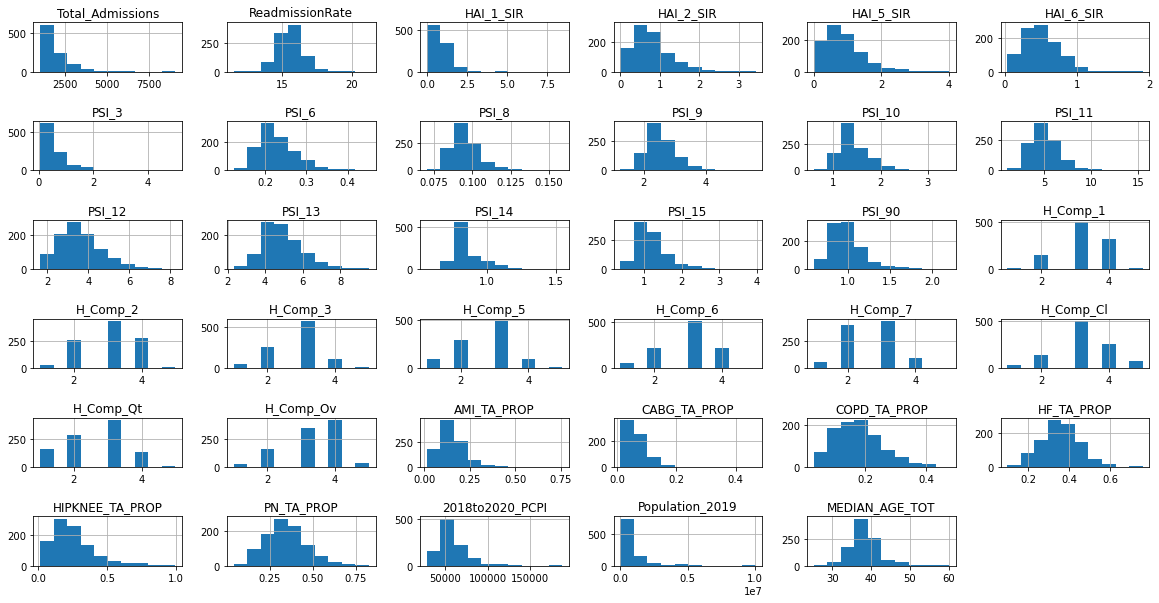

In [114]:
#A quick look at distributions of feature values for the numeric features before we move to true Exploratory Data Analysis
df.hist(figsize=(20,10))
plt.subplots_adjust(hspace=1);

There are a number of putatively predictive feature with somewhat normal looking distributions, as does our target feature (ReadmissionRate) albeit with some long rightward tails. The discretely multimodal distributions are for ratings features (eg, patient quality of care survey variables). Nothing looks alarming, though as noted before a few features have >20% missing values and we will need to consider this as we move into modeling. 

In [115]:
# For initial reference, our client hospital has these feature values
df.loc[df.Facility_ID == '310041']

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
603,310041,TOMS RIVER,NJ,Ocean,2877,16.8,0.732,0.376,0.376,0.415,...,0.128606,0.421967,192,1,very high,71,92,54195.333333,607186.0,42.4


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           1006 non-null   object 
 1   City                  1006 non-null   object 
 2   State                 1006 non-null   object 
 3   County                1006 non-null   object 
 4   Total_Admissions      1006 non-null   int32  
 5   ReadmissionRate       1006 non-null   float64
 6   HAI_1_SIR             992 non-null    float64
 7   HAI_2_SIR             994 non-null    float64
 8   HAI_5_SIR             943 non-null    float64
 9   HAI_6_SIR             947 non-null    float64
 10  PSI_3                 1005 non-null   float64
 11  PSI_6                 1005 non-null   float64
 12  PSI_8                 1005 non-null   float64
 13  PSI_9                 1005 non-null   float64
 14  PSI_10                996 non-null    float64
 15  PSI_11               

### 14. Saving Data

In [117]:
#Saving data
df.to_csv('../data/main_df_post1.csv', index=False)
other_data.to_csv('../data/other_data_post1.csv', index=False)

### 15. Summary

With the goal of building a model of hospital-specific and demographic features to predict inpatient hospital readmission rate (RR) for cases tracked by CMS/Medicare for our client (a medium-large public hospital in New Jersey), we have accrued, cleaned and wrangled the following data in a single dataframe ('df') for now (with a supplemental companion dataframe called 'other_data'):

### Hospital-Level Data From the CMS/Medicare site: 
#### Target
* 'ReadmissionRate': 30-Day Hospital-Level Readmission Rate (from 'Unplanned_Hospital_Visits-Hospital.csv')

#### Identifying and Geographic Features
* 'Facility_ID (from 'Unplanned_Hospital_Visits-Hospital.csv')
* 'City' (from 'Unplanned_Hospital_Visits-Hospital.csv')
* 'State' (from 'Unplanned_Hospital_Visits-Hospital.csv')
* 'County' (from 'Unplanned_Hospital_Visits-Hospital.csv')

#### Potentially Preditive Features

Case Load and Hospital Preparedness/Efficiency-Related Features (includes some measures from Emergency Dept [ED])
* 'Total Admissions': Total Hospital Admissions  inpatient case load (from 'Unplanned_Hospital_Visits-Hospital.csv')
* 'AMI_TA_PROP': % Initial Inpatient Admissions Due to AMI (not mutually excl.)(from ''Unplanned_Hospital_Visits-Hospital.csv') 
* 'CABG_TA_PROP': % Initial Inpatient Admissions Due to CABG (not mutually excl.)(same as above)
* 'COPD_TA_PROP': % Initial Inpatient Admissions Due to COPD (not mutually excl.)(same as above)
* 'HF_TA_PROP': % Initial Inpatient Admissions Due to HF (not mutually excl.)(same as above)
* 'HIPKNEE_TA_PROP': % Initial Inpatient Admissions Due to Hip/Knee Replacement (not mutually excl.)(same as above)
* 'PN_TA_PROP': % Initial Inpatient Admissions Due to Pneumonia (same as above)
* 'ED_MEDIAN_VISIT_MINS': Median time for ED Visits Before Pt Leaves (lower better)(Timely_and_Effective_Care-Hospital.csv)
* 'ED_LEFT_NOT_SEEN_%': % Pts leaving ED Without Being Seen (same as above)
* 'ED_VOLUME': Categorial assessment of ED caseload (same as above)- we have converted this to numerical (one hot) encoding
* '%_HCWs_FLU_VAX': Percentage of Healthcare Workers Vaccinated by Hospital (same as above)
* '%_SEPSIS_CARE': Percentage of ED pts receiving appropriate care for severe sepsis and septic shock (same as above)

Infections During Inpatient Stay-Related Features
* 'HA1_1_SIR': Central Lines Associated Bloodstream Infections (from 'Healthcare_Associated_Infections-Hospital.csv')
* 'HAI_2_SIR': Catheter Associated Urinary Tract Infections (same as above)
* 'HAI_5_SIR': MRSA Bacteremia (same as above)
* 'HAI_6_SIR': C. Diff Infections (same as above)

CMS Patient Safety and Adverse Events-Related Features (CMS Assessments of Hospital Quality)
* 'PSI_3': 'Pressure Ulcer rate' (from 'CMS_PSI_6_decimal_file.csv')
* 'PSI_6': 'Iatrogenic pneumothorax rate' (same as above)
* 'PSI_8': 'In-hospital fall with hip fracture rate' (same as above)
* 'PSI_9': 'Perioperative hemorrhage or hematoma rate' (same as above)
* 'PSI_10': 'Postoperative acute kidney injury requiring dialysis rate' (same as above)
* 'PSI_11': 'Postoperative respiratory failure rate' (from 'same as above')
* 'PSI_12': 'Perioperative pulmonary embolism or deep vein thrombosis rate' (same as above)
* 'PSI_13': 'Postoperative sepsis rate' (same as above)
* 'PSI_14': 'Postoperative wound dehiscence rate' (same as above)
* 'PSI_15': 'Abdominopelvic accidental puncture or laceration rate' (same as above)
* 'PSI_90': 'CMS Medicare PSI 90: Patient safety and adverse events composite' (same as above)

HCAHPS-Related Features (Patient Survey Star Ratings From Inpatient Stay)
* 'H_COMP_1': Nurse Communication (from 'HCAHPS-Hospital.csv')
* 'H_COMP_2': Doctor Communication (same as above)
* 'H_COMP_3': Staff Responsiveness (same as above)
* 'H_COMP_5': Communication About Medicines (same as above)
* 'H_COMP_6': Discharge Information (same as above) 
* 'H_COMP_7': Care Transition (same as above)
* 'H_COMP_Cl': Cleanliness (same as above)
* 'H_COMP_Qt': Quietness (same as above)
* 'H_COMP_Ov': Overall Hospital Rating (same as above)

Demographic Features at the County Level (Income from BEA, Population and age from Census Bureau)
* '2018to2020_PCPI': Median Per Capita Personal Income (PCPI) averaged across the years 2018-2020 (from 'lapi1121.xlsx')
* 'Population_2019': County-level population estimates for 2019
* 'MEDIAN_AGE_TOT': Median age estimate at the county level for 2020 (from cc-est2019-agesex-x.csv)(50 state-level raw files)


#### Some Points of Note Moving to Exploratory Data Analysis
* Small hospitals (<1000 inpatient cases/yr tracked by Medicare) have been filtered out of the sample. Preliminary analysis suggests that this removes a lot of noise from wide estimates of target and missing values. Also, our client hospital had 2700 cases last year, so the sample remaining of nearly 1,000 hospitals is more representative of their situation after removing the over 50% of all hospitals in the CMS database that are classified as 'small' here. 
* There are a number of putatively predictive feature with somewhat normal looking distributions, as does our target feature (ReadmissionRate) albeit with some long rightward tails. The discretely multimodal distributions are for ratings features (eg, patient quality of care survey variables). Nothing looks alarming, though as noted before a few features have >20% missing values and we will need to consider this as we move into modeling. 
* One categorial feature ('ED_VOLUME') we will convert to numeric encoding in the next stage (either one-hot or numeric). 